## Preliminaries

In [2]:
 %autosave 0

Autosave disabled


In [2]:
"""
import all necessary libraries
"""
import os,sys
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import scipy.constants as sc
import numpy as np
import math as mt
import cmath as cm
from scipy.optimize import *
from mpmath import *

In [3]:
"""
geometric unit converter (G=c=1)
To convert geometric unit → SI, multiply by factor. 
To convert SI → geometric unit, divide by factor.
"""
#constants
Ms = 1.98840987e+30 # Solar mass
c = sc.c      # Speed of light in vacuum
G = sc.G      # Gravitational constant
ϵ0 = sc.epsilon_0   # Vacuum electric permittivity

#Conversion Factors, mass, time, length and energy in units of mass
cM = Ms  #mass to solar mass factor (m)
cT = Ms*G*(c**(-3))  #mass to time factor (sec)
cL = Ms*G*(c**(-2))  #mass to length factor (m)
cE = Ms*cL**2*cT**(-2) #energy

In [4]:
#sep = float(input("Enter the initial binary separation in kilometers: "))
#r0 = sep*1000
#conversion factors is (solar mass/m), hence, (1/cL)
R0  = 42 #39.9999      #initial separation between the centers of mass in geometric units
r0  = R0*cL/1000   #initial separation between the centers of mass in km
#R0 = r0*1000/cL
print("initial separation in km =",r0) 
print("initial separation in code units =",R0) 

initial separation in km = 62.01825157633313
initial separation in code units = 42


In [5]:
#masses = list(map(float, input("Enter the the total mass in solar masses, and mass ratio q (between 1 and 2) in a single line separated by space: ").split()))
"""
we denote the first star with A and the second with B
"""
m = 2.8 #masses[0]
q = 1   #masses[1]
mA = m/(1+q)   #mass of star 1
mB = m-mA #mass of star 2 (conservation)
μ = ((mA*mB)/(mA+mB)) #reduced mass
η = μ/m #symmetric mass ratio - unitless

#radii = list(map(float, input("Enter the radii of the stars in a single line separated by space: ").split()))  
rA = 11 #radii[0]*1000 # radius NS A in km
rB = 11 #radii[1]*1000 # radius NS A in km
rS = float((2.0*G*m*Ms/(c**2))/1000) # Schwarzschild radius
#initial and final radial separations in units of solar mass 
Ri = 1000*(r0-(rA+rB))/cL #initial separation between the surfaces
RT = 1000*(rA+rB)/cL       #radius where neutron stars touch
print ("mA = ", mA)
print ("mB = ", mB)
print ("μ,η  = ", μ,η)
print ("mass rescaled mA, mB = ", mA/m, mB/m)
print ("mass rescaled separation = ", R0/m)
print("mass rescaled initial surface separation = ", Ri/m)
print("mass rescaled touch radius = ",RT/m)
print("Schwarzchild Radius in km = ",rS)

mA =  1.4
mB =  1.4
μ,η  =  0.7 0.25
mass rescaled mA, mB =  0.5 0.5
mass rescaled separation =  15.000000000000002
mass rescaled initial surface separation =  9.678985756413491
mass rescaled touch radius =  5.321014243586509
Schwarzchild Radius in km =  8.26910021017775


In [6]:
"""
The light ring: this is an important quantity marking when the 
PNN approximation breaks down and the matching to BoB happens
It is given in terms of the Schwarzchild radius and the spin of the remnant
Will take it's location around 2rS.
"""
fLR = 2.20              # Light Ring factor: TUNE TO CHANGE THE MATCHING
RLR = fLR*rS*1000/cL  # Light Ring radius

#accuracy check
print("mass rescaled light ring = ",RLR/m)

mass rescaled light ring =  4.400000000000001


In [7]:
"""
initial and final value of the frequencies and velocities from Kepler's Law 
"""
Ω0_SI  = float((G*m*Ms/(r0*1000)**3)**(1/2))  #initial
Ωt_SI  = float((G*m*Ms/((rA+rB)*1000)**3)**(1/2))  #when stars touch
ΩLR_SI  = float((G*m*Ms/(2*rS*1000)**3)**(1/2))  #when stars touch
# note that velocities do not depend on mass
v0_SI = float((G*m*Ms/(r0*1000))**(1/2)) #initial
vt_SI = float((G*m*Ms/((rA+rB)*1000))**(1/2)) ##when stars touch
vLR_SI = float((G*m*Ms/(2*rS*1000))**(1/2)) ##at light ring

#Accuracy check
print("Initial frequency = {n:e} Hz".format(n=Ω0_SI/(np.pi)))
print("Touch frequency touch = {n:e} Hz".format(n=Ωt_SI/(np.pi)))
print("Light Ring frequency = {n:e} Hz".format(n=ΩLR_SI/(np.pi)))

print("\n Initial velocity = {n:e} m/s".format(n=v0_SI))
print("Touch velocity = {n:e} m/s".format(n=vt_SI))
print("Light Ring velocity= {n:e} m/s".format(n=vLR_SI))

Initial frequency = 3.972882e+02 Hz
Touch frequency touch = 1.880403e+03 Hz
Light Ring frequency = 2.885045e+03 Hz

 Initial velocity = 7.740608e+07 m/s
Touch velocity = 1.299641e+08 m/s
Light Ring velocity= 1.498962e+08 m/s


In [8]:
print("Frequency in geometric units")
#Notation for frequencies: 
#capital letters for orbital quantities, lowercase for GW quantities
Ω0  = cT*Ω0_SI #float((R0)**(-3/2))   #initial
Ωt  = cT*Ωt_SI #float((2*RNS)**(-3/2))  #when stars touch
ΩLR = cT*ΩLR_SI #float((RLR)**(-3/2)) #final/light ring

#Accuracy check
print("Initial Orbital frequency = {n:e}".format(n=Ω0))
print("Touch Orbital frequency = {n:e}".format(n=Ωt))
print("Light Ring = {n:e}".format(n=ΩLR))

Frequency in geometric units
Initial Orbital frequency = 6.147593e-03
Touch Orbital frequency = 2.909714e-02
Light Ring = 4.464286e-02


## Inspiral for BBH, mass rescaled to 1

In [9]:
"""
post Newtonian parameter/Integration Bounds (v/c)^2
initial and at light ring
"""
MΩ0  = m*Ω0 #float((R0)**(-3/2))   #initial
MΩt  = m*Ωt #float((2*RNS)**(-3/2))  #when stars touch
MΩLR = m*ΩLR #float((RLR)**(-3/2)) #final/light ring

# rescaled radii
R0oM = R0/m
RioM = Ri/m
RToM = RT/m
RLRoM = RLR/m

x0  = (v0_SI/c)**2   #initial
xt  = (vt_SI/c)**2   #touch
xLR = (vLR_SI/c)**2  #light ring

#Accuracy check
print("{}_initial =".format("Ω"),MΩ0)
print("{}_touch =".format("Ω"),MΩt)
print("{}_lightring =".format("Ω"),MΩLR)

print("x0 in geometric units =",x0)
print("x0 BBH in geometric units =",(MΩ0)**(2/3))   #initial
print("xt =",xt)
print("xLR =",xLR)

print("rescaled initial separation = ",R0oM)
print("rescaled initial separation between surfaces = ",RioM)
print("surfaces touch = ",RToM)
print("light ring = ",RLRoM)

Ω_initial = 0.017213259316477405
Ω_touch = 0.08147199815361217
Ω_lightring = 0.12499999999999996
x0 in geometric units = 0.06666666666666665
x0 BBH in geometric units = 0.06666666666666667
xt = 0.18793409568585795
xLR = 0.25
rescaled initial separation =  15.000000000000002
rescaled initial separation between surfaces =  9.678985756413491
surfaces touch =  5.321014243586509
light ring =  4.400000000000001


In [10]:
"""Time to collision (Tc), Time to light ring(T_LR),
and time to touch, when the PN approx breakdown (TPNf) in geometric units
"""
TcSI = float((5/256)*((c**5)/(G**3)*(r0)**4/(η*((m*Ms)**3))))
Tc = float((5/256)*((R0)**4/(η*(m**3))))
Tt = float((5/256)*((RT)**4/(η*(m**3))))
Tc_BBH = float((5/256)*((R0oM)**4/(η*(1**3))))

print("time to collision, SI units","{}".format(str(TcSI)))
print("time to collision, geometric units","{}".format(str(Tc)))
print("time to touch, geometric units","{}".format(str(Tc-Tt)))
print("time to collision BBH, geometric units","{}".format(str(Tc_BBH)))

time to collision, SI units 5.454596418617532e-14
time to collision, geometric units 11074.218750000002
time to touch, geometric units 10898.860683791136
time to collision BBH, geometric units 3955.078125000002


### Observe that we must rescale when going from BNS to BBH
$$
\Omega \rightarrow m \Omega; ~~
r \rightarrow r/m; ~~
t \rightarrow t/m.
$$

In [11]:
""" 
Must define the time array;
An upper time limit for the PN evolution is 
approx equal to light ring time, but we might stop 
when the ODE becomes stiff
"""
MTPNf = 3455 #2785 #1910 # untill the ODE becomes stiff
dt= 0.1 #0.05 #time step
t0=0 #initial time set at t=0

#numberofelements=mt.ceil(MTPNf/(dt))  #number of time steps/elements in time array rounded up to nearest integer 
#MtPNarr=np.linspace(t0,MTPNf,numberofelements) #time array created from 0 to Tbreak 
MtPNarr=np.arange(t0,MTPNf, dt, dtype=np.float64)
#Accuracy check
print(len(MtPNarr))
print("Numeric time to collision",MTPNf,MTPNf*cT)

34550
Numeric time to collision 3455 0.01701757121812639


In [12]:
"""
Post Newtonian approximation of v^2/c^2=x (one body formulation of two body prob) as funct. of time
"""
# define post newtonian parameters and use them to define 1st 
# derivative of x=(v^2/c^2)

def xiPN(x,MtPNarr):
    
    xi0PN = (64./5.)*η    
    
    xi0p5PN = 0.
    
    xi1PN = -(4./105.)*η*(743.+924.*η)
    
    xi1p5PN = 160.85*η
    
    xi2PN = (2.*η*(34103.+122949.*η+59472.*η**2))/2835.
    
    xi2p5PN = (-248.874-950.018*η)*η
    
    xi3PN = (1./4677750.)*η*(8951189331.+275.*(-56198689.+2045736.*(np.pi)**2)*η \
             +36152325.*η**2-129475500.*η**3+976250880.*(np.log(x/x0)))

    
    xi3PNHT = η*(-22.2337-(109568./525.)*(np.euler_gamma) \
               -(109568./525.)*(np.log(x**(3./2.)/x0)))
    
    xi3p5PN = (1./189.)*(np.pi)*η*(-2649.+143470.*η+147112.*η**2)
    
    xi4PN = -(388./1215.)*η*(-6191.63+29700.4*η-14837.5*η**2+(18929389./10864.)*η**3 \
              +η**4+(np.euler_gamma)*(-1133.77+(369792./3395.)*η) \
              +(-566.885+(20506176./3395.)*η)*(np.log(x)))
    
    xi4p5PN = (64./5.)*η*((205./6.)*(np.pi)**3*η+(np.pi)*((343801320119./745113600.) \
               -(6848./105.)**(np.euler_gamma)-(51438847./48384.)*η+(42680611./145152.)*η**2 \
               +(9731./1344.)*η**3-(13696./105.)*(np.log(2)))-(3424./105.)*(np.pi)*(np.log(x)))
    
    xi5PN = -(11567./4860.)*η*(-3862.58+10777.1*η-16459.*η**2+2765.87*η**3 \
              -158.934*η**4+η**5+(np.euler_gamma)*(32.3594-628.209*η \
              +13.3968*η**2)+(16.1797-5484.07*η-6163.97*η**2)*(np.log(x)))
    
    xi5p5PN = (98374./945.)*η*(433.679+(np.euler_gamma)*(20.4465-4.19889*η) \
              -1411.45*η+1595.21*η**2-199.563*η**3+(np.pi)*η**4 \
              +(10.2233-232.842*η)*(np.log(x)))
    
    xi6PN = -(155377./131220.)*η*(-140112.-1436.89*(np.euler_gamma)**2+511358.*η \
              -361163.*η**2+82689.*η**3-7012.92*η**4+157.381*η**5 \
              +η**6+(np.euler_gamma)*(26642.9-26708.6*η+720.722*η**2 \
              +12.9198*η**3)+(13321.4-1436.89*(np.euler_gamma)-75688.9*η \
              + 23085.7*η**2+26072.7*η**3)*(np.log(x))-359.221*(np.log(x))**2)
    
    xiPN = (((x)**5))*(xi0PN*((x)**0)+xi0p5PN*((x)**(1/2))+xi1PN*((x)**1) \
                     +xi1p5PN*((x)**(3/2))+xi2PN*((x)**2)+xi2p5PN*((x)**(5/2)) \
                     +(xi3PN+xi3PNHT)*((x)**3)+xi3p5PN*((x)**(7/2)) \
                     +xi4PN*((x)**4)+xi4p5PN*((x)**(9/2))+xi5PN*((x)**5) \
                     +xi5p5PN*((x)**(11/2))+xi6PN*((x)**6))    
    return (xiPN)

xPN last =  0.2909961227925077


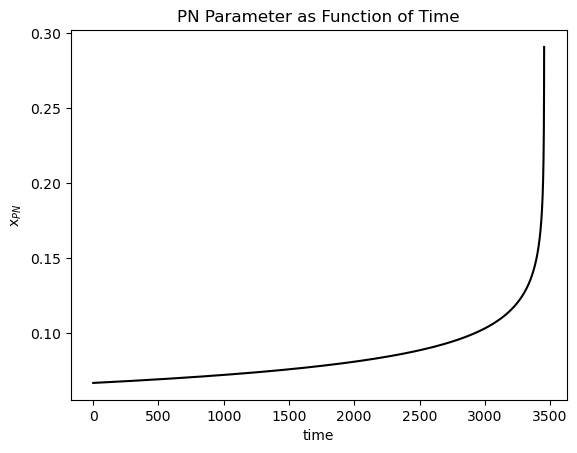

In [13]:
# solve the ordinary differential equation X' = xdot
xPN=odeint(xiPN,x0,MtPNarr,hmin=1e-32) #x(t) as a 1 column array
#atol=1.0e-10, rtol=1.0e-10
xPNarr = np.array(xPN).flatten()

# plot x(t)agaist corresponding "tPNarr" values 
#plt.rcParams.update({'font.size': 14})  # increase the font size
plt.title("PN Parameter as Function of Time")
plt.xlabel("time")
plt.ylabel("x$_{PN}$")
plt.plot(MtPNarr,xPNarr,'k')

#sanity check
print("xPN last = ", xPNarr[len(MtPNarr)-1])

In [14]:
"""
vPN as function of time (in geometric units)
"""

vPNarr=xPNarr**(1/2)

#sanity check
print("v last = ", (xPNarr[len(MtPNarr)-1])**(1/2))

v last =  0.539440564652407


In [15]:
"""
Radial Separation as a function of time (in geometric units)
"""
#define expansion coeff.'s

def rPN(x):
    rho0PN = 1.
    rho1PN = -1.+(1./3.)*η
    rho2PN = (1./36.)*η*(171.+4.*η)
    rho3PN = (-(24257./2520.)+(41./192.)*(np.pi)**2)*η \
          -(37./12.)*η**2+(2./81.)*η**3

    rPN = ((rho0PN)*((x)**(-1))+(rho1PN)*((x)**(0)) \
      +(rho2PN)*((x)**(1))+(rho3PN)*((x)**(2)))
    
    return rPN

rPNarr = np.array(rPN(xPN)).flatten()
rdotarr=np.gradient(rPNarr,MtPNarr)

#sanity check
print("rPN last = ", rPNarr[len(MtPNarr)-1])
#print(RT/m, RLR/m)

rPN last =  2.691939913336624


In [16]:
# find position where stars touch, and light ring
"""
Change the domain if not found
"""
t, tT, tLR = 0,0,0
for t in range(len(MtPNarr)):
    if (0.999*(RT/m) < rPNarr[t] < 1.001*(RT/m)):
        tT = t
#        print("stars touch index",(2*RNS/rPNarr[tT]), tT)

for t in range(len(MtPNarr)):
    if (0.999*(RLR/m) < rPNarr[t] < 1.001*(RLR/m)):
        tLR = t
#        print("light ring index",(RLR/rPNarr[tLR]), tLR)
#the last value for the time found will be filled in           
numLR = tLR
numT = tT
numL = len(MtPNarr)-1

#sanity check
print("Last point",rPNarr[numL],[MtPNarr[numL]])
print("light ring",(rPNarr[numLR]),[MtPNarr[numLR]] )
print("surfaces touch",(rPNarr[numT]),[MtPNarr[numT]])

print("xPN LR => ",xPNarr[numLR])

for t in range(len(MtPNarr)):
    if (0.999 < xPNarr[t]/xLR < 1.001):
        tX = t
numX = tX
print("rPN for xLR = 0.25 => ",rPNarr[numX])

Last point 2.691939913336624 [3454.9]
light ring 4.400342902838497 [3444.2000000000003]
surfaces touch 5.317659595973631 [3421.8]
xPN LR =>  0.19367109100951307
rPN for xLR = 0.25 =>  3.2525102075179504


In [17]:
"""
PN angular frequency (from Keplers law in geometric units, x^3/2)
"""
MΩPN = (xPN)**(3/2)
MΩPNarr = np.array(MΩPN).flatten()
MΩdotPNarr = np.gradient(MΩPNarr,MtPNarr)

print("frequency for last point",MΩPNarr[numL])
print("frequency for surface touch",MΩPNarr[numT])
print("frequency for light ring=4",MΩPNarr[numLR])
print("frequency for light ring=3.25",MΩPNarr[numX])

frequency for last point 0.15697511279085152
frequency for surface touch 0.0664712805457362
frequency for light ring=4 0.08523092437334315
frequency for light ring=3.25 0.12499724755878967


In [18]:
# Create cubic interpolators for Ω(t) to be able to integrate it.
#https://stackoverflow.com/questions/41860451/odeint-with-multiple-parameters-time-dependent
MΩPNinterp = interp1d(MtPNarr, MΩPNarr, bounds_error=False, fill_value="extrapolate",kind = "cubic")

# Create the function required by the ODE
def MΦPNdot (y, t):
    MΦPNdot = MΩPNinterp(t)
    return MΦPNdot

MΩ0 = (xPNarr[0])**(3/2)  # Initial Condition

# Solving the ODE
MΦPN = odeint(MΦPNdot, MΩ0, MtPNarr) #hmin=1e-32

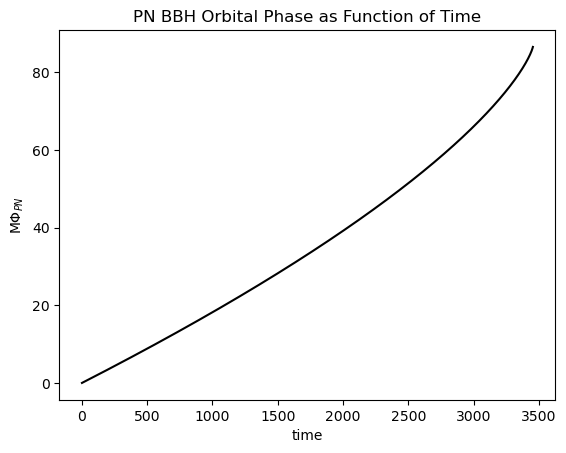

In [19]:
# Plotting the orbital phase
MΦPNarr = np.array(MΦPN).flatten()
plt.title("PN BBH Orbital Phase as Function of Time")
plt.xlabel("time")
plt.ylabel("MΦ$_{PN}$")
plt.plot(MtPNarr,MΦPNarr,'k')

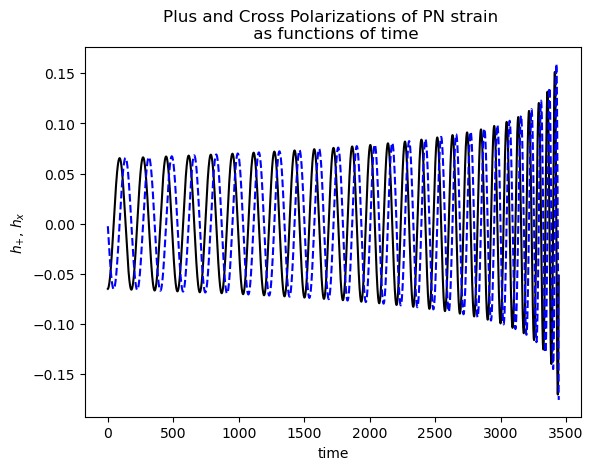

In [20]:
"""
Building the PN Amplitude and Strain: attention, this is for BBH!
"""
reAPNarr = (1./(rPNarr)-(rdotarr**2) + (rPNarr**2)*(MΩPNarr**2))
imAPNarr = 2.*(rPNarr)*(rdotarr)*(MΩPNarr)

hplusPNarr = -2*η*((reAPNarr)*np.cos(2*MΦPNarr) + (imAPNarr)*np.sin(2*MΦPNarr))
hcrosPNarr = -2*η*((reAPNarr)*np.sin(2*MΦPNarr) - (imAPNarr)*np.cos(2*MΦPNarr))

#plot hplus and hcross up to the light ring
plt.title("Plus and Cross Polarizations of PN strain \n as functions of time")
plt.xlabel("time")
plt.ylabel("$h_{+}$, $h_{x}$")
plt.plot(MtPNarr[t0:numLR],hplusPNarr[t0:numLR],color='black',linewidth=1.5)
plt.plot(MtPNarr[t0:numLR],hcrosPNarr[t0:numLR],linestyle='dashed', color='blue',linewidth=1.5)

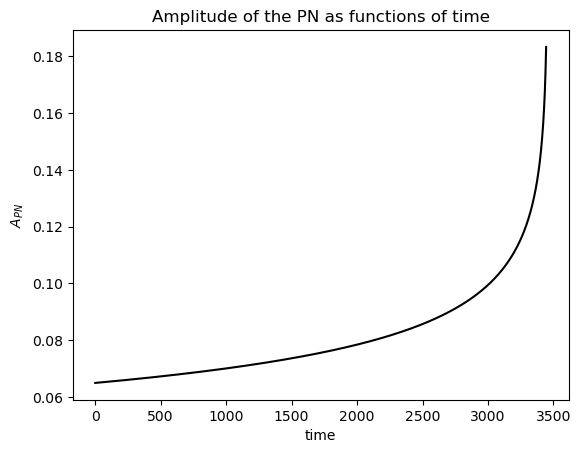

In [21]:
#Amplitude/Modulus of strain for inspiral/PN approx
AmpPNarr = np.sqrt(((hplusPNarr)**2)+((hcrosPNarr)**2))

#plot the PN amplitude of the strain
plt.title("Amplitude of the PN as functions of time")
plt.xlabel("time")
plt.ylabel("$A_{PN}$")
plt.plot(MtPNarr[t0:numLR],AmpPNarr[t0:numLR],'k')

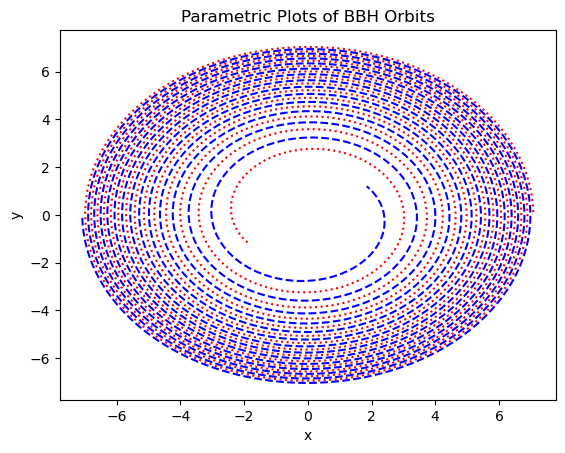

In [22]:
"""
Individual orbits, must use the orbital phase
"""
rAPNarr = (mB/m)*rPNarr
rBPNarr = -(mA/m)*rPNarr

rAPNxarr = rAPNarr*np.cos(MΦPNarr)
rAPNyarr = rAPNarr*np.sin(MΦPNarr)

rBPNxarr = rBPNarr*np.cos(MΦPNarr)
rBPNyarr = rBPNarr*np.sin(MΦPNarr)

#plot the Orbits
plt.title("Parametric Plots of BBH Orbits")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(rAPNxarr[t0:numLR],rAPNyarr[t0:numLR],linestyle='dotted', color='red',linewidth=1.5)
plt.plot(rBPNxarr[t0:numLR],rBPNyarr[t0:numLR],linestyle='dashed', color='blue',linewidth=1.5)

## Building the Merger, BBH
Rescaled with mass (mass normalized to 1)

In [23]:
"""
initialization
frequencies: capital letters for orbital quantities, 
lowercase for GW quantities l=m=2
"""
##Values taken from fit with numerical data
χf  = 0.69 #estimated final spin of resulting black hole
χNS  = 2.1e-3 #estimated initial spin of neutron stars black hole
q1, q2, q3  = 0.7, 1.4187, -0.499 # coefficients Q22
f1, f2, f3 = 1.5251, -1.1568, 0.1292 # coefficients Ω22b
E0, E2, E4 = 0.048332, 0.000743, 0.000124 # coefficients EGW
## note that the NS will eject mass during the collision as well! 
##We can estimate disk mass at 20% of the total mass mass of the neutron star
MD = 0.0 #0.02 #estimated ejected/disk mass

Q22QNM = q1 + q2*(1 - χf)**(q3) #Quality Factor, Dominant 22 mode
MfΩ22QNM = f1 +f2*(1 - χf)**(f3) #QNM Frequency Dominant 22 Mode 

χeff = χNS*(1 - q)/(1 + q) 
EGW = E0 + E2*χeff**(2) + E4*χeff**(4)
Mf = (1 - EGW - MD)
Ω22QNM = MfΩ22QNM/(Mf)

τ = 2*(Q22QNM/Ω22QNM) #Damping Time

ΩQNM = Ω22QNM/2 #final frequency of fundamental QNM

#fGW = 0.048411 #estimated fraction of mass converted in GW energy
#fNS = 0.05     #estimated fraction of mass ejected during the collision
#Mf  = (1-fGW)*M

##sanity check
print("Mf = ", Mf)
print("Q22QNM =",Q22QNM)
print("Ω22QNM =",Ω22QNM)
print("τ =",τ)

Mf =  0.951668
Q22QNM = 3.2450779217207257
Ω22QNM = 0.5576979422362189
τ = 11.637403246312278


In [24]:
"""
Set initial values as the final values of inspiral stage/PN expans. at light ring
This can be tuned
"""
A0 = 1; t0 = 0

## there are different choices possible here
## let's take the last value of the frequency from the PN evolution

MΩiX = MΩPNarr[numX] #assume light ring 3.25 for orbital freq of PN
MΩdotiX = MΩdotPNarr[numX] #assume light ring 3.25 for angular accel at last PN point

MΩiLR = MΩPNarr[numLR] #assume light ring 4 for freq of PN
MΩdotiLR = MΩdotPNarr[numLR] #assume light ring 4 for angular accel at light ring freq of PN

MΩiT = MΩPNarr[numT] #assume freq PN at touch 
MΩdotiT = MΩdotPNarr[numT] #assume angular accel PN at touch

#accuracy check
print("Frequency at LR 3.25 point",MΩiX)
print("Frequency at LR 4.0 point",MΩiLR)
print("Frequency at touch point",MΩiT)

Frequency at LR 3.25 point 0.12499724755878967
Frequency at LR 4.0 point 0.08523092437334315
Frequency at touch point 0.0664712805457362


In [25]:
"""
Initial value for the time of overlap of models
"""
tiX = t0-((τ/2)*np.log((((ΩQNM**4)-(MΩiX**4))/(2*τ*(MΩiX**3)*MΩdotiX))-1))
tiLR = t0-((τ/2)*np.log((((ΩQNM**4)-(MΩiLR**4))/(2*τ*(MΩiLR**3)*MΩdotiLR))-1))
tiT = t0-((τ/2)*np.log((((ΩQNM**4)-(MΩiT**4))/(2*τ*(MΩiT**3)*MΩdotiT))-1))
#ti=round(ti,2)
print("BoB ti at PN LR 3.25",tiX)
print("BoB ti at PN LR 4.0",tiLR)
print("BoB ti at PN touch",tiT)

BoB ti at PN LR 3.25 -12.125316531872155
BoB ti at PN LR 4.0 -32.16408024102246
BoB ti at PN touch -43.86476968369108


In [26]:
"""
Frequency and Amplitude Calculations
"""
# we pick the frequency at light ring
MΩi = MΩiLR
MΩdoti = MΩdotiLR
ti = tiLR

kB = (((ΩQNM**4)-(MΩi**4))/(1-np.tanh((ti-t0)/τ)))

#frequency of fundamental mode as funct of t
def MΩBoB(t):    
    MΩBoB = ((MΩi**4)+(kB*(np.tanh((t-t0)/τ)-np.tanh((ti-t0)/τ))))**(1/4)
    return MΩBoB

#frequency of dominant mode as funct of t
def MωBoB(t):
    MωBoB = 2*MΩBoB(t)
    return MωBoB

# The amplitude of the Weyl scalar Ψ4
def Ψ4(t):
    Ψ4 = A0/np.cosh((t-t0)/τ)
    return Ψ4

#The BoB amplitude for the dominant mode
def AmpBoB(t):
    AmpBoB = ((Ψ4(t))/(MΩBoB(t))**2)
    return AmpBoB

In [27]:
#we define the time array for the BoB
tBoBmax = 250
tBoBmin = np.ceil(ti/(dt)+1)*dt
Nmax = int((tBoBmax-tBoBmin)/dt)

MtBoBarr = np.linspace(tBoBmin, tBoBmax, Nmax)
MΩBoBarr = np.array(MΩBoB(MtBoBarr)).flatten()
MΩdotBoBarr=np.gradient(MΩBoBarr,MtBoBarr)

#find maximum for BoB angular acceleration
maxMΩdotBoB = np.max(MΩdotBoBarr)
# Get the indices of maximum element in numpy array
tMΩdotmaxBoB = np.where(MΩdotBoBarr == maxMΩdotBoB) #location of max BoB amplitude
print('Max BoB angular acceleration: ', maxMΩdotBoB, tMΩdotmaxBoB[0])
print('time of max. angular acceleration',MtBoBarr[tMΩdotmaxBoB[0]])

Max BoB angular acceleration:  0.006291618592242698 [243]
time of max. angular acceleration [-7.69137992]


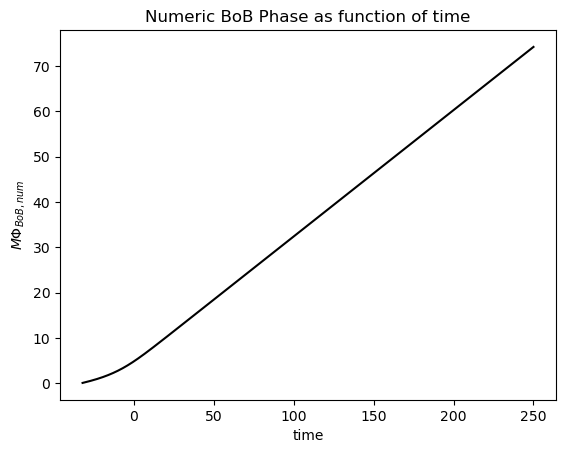

In [28]:
# Create the function required by the ODE
def MΦdotBoB (y, t):
    MΦdotBoB = MΩBoB(t)
    return MΦdotBoB

# Solving the ODE
MΦBoBnum = odeint(MΦdotBoB, MΩi, MtBoBarr)
MΦBoBnumarr = np.array(MΦBoBnum).flatten()
plt.title("Numeric BoB Phase as function of time")
plt.xlabel("time")
plt.ylabel("$M\Phi_{BoB,num}$")
plt.plot(MtBoBarr,MΦBoBnumarr,'k')

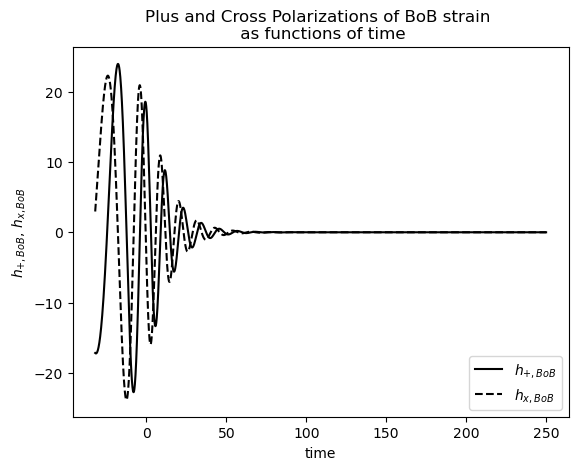

In [29]:
"""
Calculate the Strain
"""
AmpBoBarr = np.array(AmpBoB(MtBoBarr)).flatten()

hplusBoBarr = -AmpBoBarr*np.cos(2*MΦBoBnumarr)
hcrosBoBarr = +AmpBoBarr*np.sin(2*MΦBoBnumarr)

plt.title("Plus and Cross Polarizations of BoB strain \n as functions of time")
plt.plot(MtBoBarr, hplusBoBarr,'k')
plt.plot(MtBoBarr, hcrosBoBarr,linestyle='dashed', color='black',linewidth=1.5)
plt.xlabel("time")
plt.ylabel("$h_{+,BoB}$, $h_{x,BoB}$")
plt.legend(("$h_{+,BoB}$","$h_{x,BoB}$"),loc="lower right")

## Hybrid Waveform

We shift the time for the PN and BoB to correspond to 0 at the time the stars touch, to match them.

In [30]:
"""
We must loop the index.
"""
#translate the time array from the PN approx/inspiral stage 
MtarrshiftPN=np.zeros(numLR)
p=0
for e in MtPNarr[0:numLR]:
    MtarrshiftPN[p]=e - MtPNarr[numLR]
    p=p+1

In [31]:
#translate the time array for freq. from the BoB approx/merger stage 

MtarrshiftBoB=np.zeros(len(MtBoBarr))
p=0
for e in MtBoBarr:
    MtarrshiftBoB[p]= e - MtBoBarr[0]
    p=p+1

0.08523092437334315 0.08550361904929127 -0.0002726946759481208


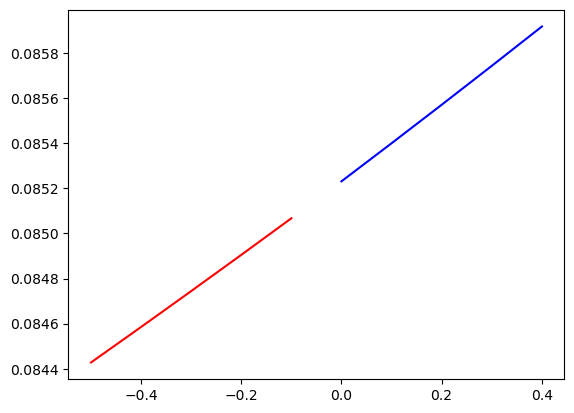

In [32]:
# Fit the frequency
#In Python last element in the array has the index N-1
lastΩPN = MΩPNarr[numLR]
firstΩNR = MΩBoBarr[0]
ΔΩ = lastΩPN - firstΩNR
print(lastΩPN, firstΩNR, ΔΩ)

#Plotting Together Pt1
#frequency zoomed in at the LR to check on the kink
plt.plot(MtarrshiftPN[numLR-5:numLR], MΩPNarr[numLR-5:numLR],"r")
plt.plot(MtarrshiftBoB[0:5], MΩBoBarr[0:5]+ΔΩ,"b")

85.40672264850879 0.08523092437334315 85.32149172413544


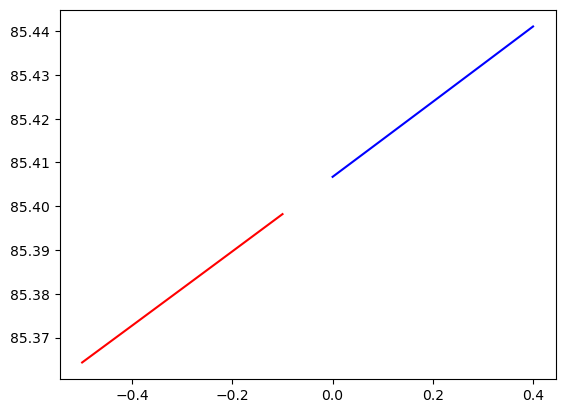

In [33]:
# Fit the phase
lastΦPN = MΦPNarr[numLR]
firstΦNR = MΦBoBnumarr[0]
ΔΦ = lastΦPN - firstΦNR
print(lastΦPN, firstΦNR, ΔΦ)

#phase zoomed in at the LR to check on the kink
plt.plot(MtarrshiftPN[numLR-5:numLR], MΦPNarr[numLR-5:numLR],"r")
plt.plot(MtarrshiftBoB[0:5], (MΦBoBnumarr[0:5]+ΔΦ),"b")

#Checking the hybrid array
#print("\n")
#print(MtarrshiftPN[numLR-5:numLR])
#print(MΦPNarr[numLR-5:numLR])
#print(MtarrshiftBoB[0:3])
#print(MΦBoBnumarr[0:3]+ΔΦ)
#print(len(MΦBoBnumarr)+len(MΦPNarr[0:numLR]))

In [34]:
#Building hybrid time array    
Mtarrhyb=np.zeros(len(MtarrshiftPN)+len(MtarrshiftBoB))
p=0
for e in range(len(MtarrshiftPN)):
    Mtarrhyb[p]=MtarrshiftPN[e]
    p=p+1
for e in range(0,len(MtarrshiftBoB)):
    Mtarrhyb[p]=MtarrshiftBoB[e]
    p=p+1

#Building Hybrid Phase
Mϕhybarr=np.zeros(len(Mtarrhyb))
p=0
for e in range(len(MtarrshiftPN)):
    Mϕhybarr[p]=2*MΦPNarr[e]
    p=p+1
for e in range(0,len(MtarrshiftBoB)):
    Mϕhybarr[p]=2*(MΦBoBnumarr[e] + ΔΦ)
    p=p+1
    
#Building Hybrid Angular Frequency 
Mωhybarr=np.zeros(len(Mtarrhyb))
p=0
for e in range(len(MtarrshiftPN)):
    Mωhybarr[p]=2*MΩPNarr[e]
    p=p+1
for e in range(len(MtarrshiftBoB)):
    Mωhybarr[p]=2*(MΩBoBarr[e]+ΔΩ)
    p=p+1 

In [35]:
#print(len(MΦBoBnumarr)+len(MΦPNarr[0:numLR]), len(Mtarrhyb))
#print(Mtarrhyb[numLR-3:numLR+3])
#print(Mϕhybarr[numLR-3:numLR+3])

In [36]:
#Calculate the hybrid PN parameter
Xhybarr = (Mωhybarr/2.)**(2/3)

#Calculate the hybrid velocity
Vhybarr = (Xhybarr)**(1/2)

Rhybarr = np.array(rPN(Xhybarr)).flatten()

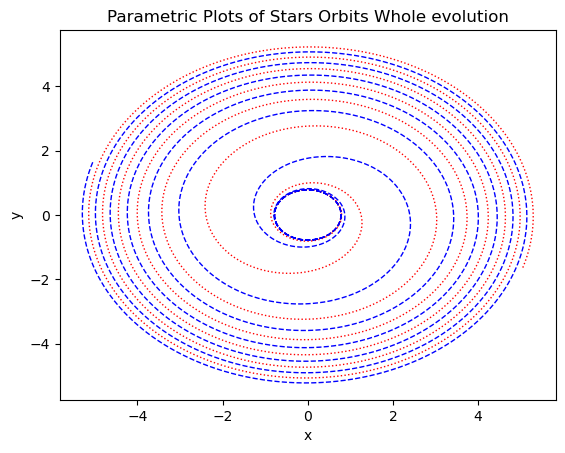

In [37]:
"""
Now will calculate the individual orbits for the whole evolution
"""
rAhybarr = (mB/m)*Rhybarr
rBhybarr = -(mA/m)*Rhybarr

rAhybxarr = rAhybarr*np.cos(Mϕhybarr/(2))
rAhybyarr = rAhybarr*np.sin(Mϕhybarr/(2))

rBhybxarr = rBhybarr*np.cos(Mϕhybarr/(2))
rBhybyarr = rBhybarr*np.sin(Mϕhybarr/(2))

#plot the starts orbits as they inspiral
plt.title("Parametric Plots of Stars Orbits Whole evolution")
plt.xlabel("x")
plt.ylabel("y")
plt.plot(rAhybxarr[numLR-10000:numLR+1000],rAhybyarr[numLR-10000:numLR+1000],linestyle='dotted', color='red',linewidth=1)
plt.plot(rBhybxarr[numLR-10000:numLR+1000],rBhybyarr[numLR-10000:numLR+1000],linestyle='dashed', color='blue',linewidth=1)

In [38]:
#define the function for the amplitude
def Amp(hplus,hcros):
    Amp=np.sqrt(((hplus)**2)+((hcros)**2))
    return Amp

#find maximum for BoB amplitude
maxAmpBoB = np.max(abs(AmpBoBarr))
# Get the indices of maximum element in numpy array
tAmaxBoB = np.where(AmpBoBarr == maxAmpBoB) #location of max BoB amplitude
print('Max BoB Amplitude: ', maxAmpBoB, tAmaxBoB[0])
#form BoB norm amplitude
      
NormAmpBoBarr = AmpBoBarr/maxAmpBoB

# find first BoB amplitude
firstNormAmpBoB = NormAmpBoBarr[0]
print('First BoB Amplitude: ',firstNormAmpBoB)

#find PN amplitude when stars touch
lastAmpPN = AmpPNarr[numLR]
print('Last PN Amplitude: ',lastAmpPN)

#form PN norm amplitude
NormAmpPNarr = AmpPNarr*firstNormAmpBoB/lastAmpPN #-0.05

Max BoB Amplitude:  24.056656755302228 [165]
First BoB Amplitude:  0.7241865959827515
Last PN Amplitude:  0.18346353515755803


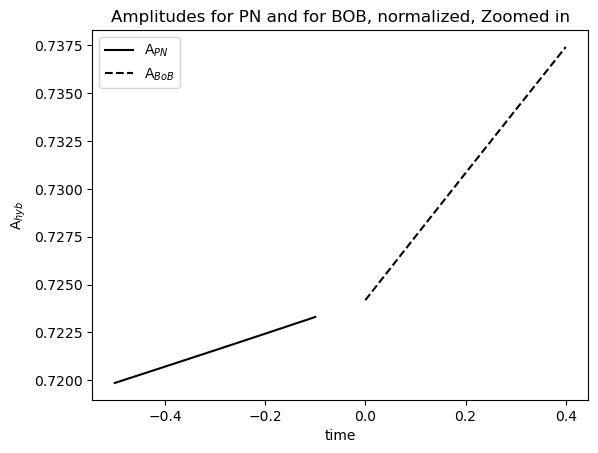

In [39]:
#plot the normalized amplitudes
plt.title("Amplitudes for PN and for BOB, normalized, Zoomed in")
plt.plot(MtarrshiftPN[numLR-5:numLR],NormAmpPNarr[numLR-5:numLR],"k")
plt.plot(MtarrshiftBoB[0:5],NormAmpBoBarr[0:5],linestyle='dashed', color='black',linewidth=1.5)
plt.xlabel("time")
plt.ylabel("A$_{hyb}$")  
plt.legend(("A$_{PN}$","A$_{BoB}$"),loc="upper left")

In [40]:
#form the normalized hybrid amplitude
Amphybarr=np.zeros(len(Mtarrhyb))
p=0
for e in range(len(MtarrshiftPN)):
    Amphybarr[p]=NormAmpPNarr[e]
    p=p+1
for e in range(0,len(MtarrshiftBoB)):
    Amphybarr[p]=NormAmpBoBarr[e]
    p=p+1

#find maximum for BoB angular acceleration
maxAhyb = np.max(Amphybarr)
# Get the indices of maximum element in numpy array
maxMtarrhyb = np.where(Amphybarr == maxAhyb) #location of max BoB amplitude
print('Max hybrid amplitude: ', maxAhyb, maxMtarrhyb[0][0])
print('time of max. hybrid amplitude',Mtarrhyb[maxMtarrhyb[0][0]])
#print(Mtarrhyb[numLR-3:numLR+3])
#print(Amphybarr[numLR-3:numLR+3])

numM = maxMtarrhyb[0][0]
print(numM)
#print(Mtarrhyb[numLR-3:numLR+3],Amphybarr[numLR-3:numLR+3])
#print("\n")
#print(Mtarrhyb[numLR-3:numLR],NormAmpPNarr[numLR-3:numLR])
#print("\n")
#print(Mtarrhyb[numLR:numLR+3],NormAmpBoBarr[0:3])

Max hybrid amplitude:  1.0 34607
time of max. hybrid amplitude 16.505853139411137
34607


In [41]:
#shift the hybrid time array to set 0 at merger (the maximum amplitude)
#Building hybrid time array    
MtarrhybM=np.zeros(len(Mtarrhyb))
p=0
for e in range(len(MtarrhybM)):
    MtarrhybM[p]=Mtarrhyb[e] - Mtarrhyb[numM]
    p=p+1

numF = len(MtarrhybM)

print(MtarrhybM[numM-3:numM+3])
print(Amphybarr[numM-3:numM+3])

[-0.30010642 -0.20007095 -0.10003547  0.          0.10003547  0.20007095]
[0.99994462 0.99998097 0.99999943 1.         0.99998268 0.99994747]


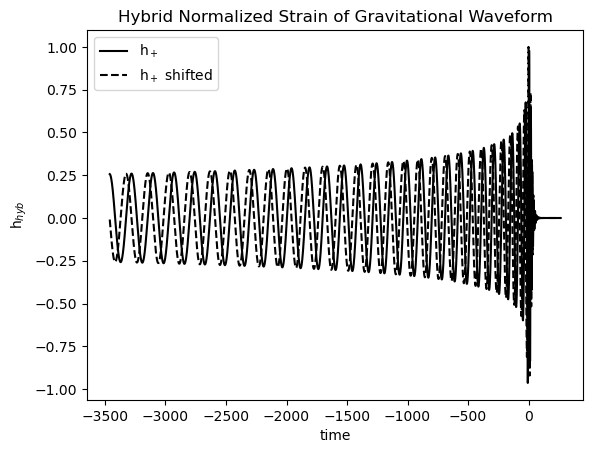

In [42]:
#Finally, form the strain of the gravitational waves
#define the functions
def hplushyb(Amp,ϕ):
    hplushyb=Amp*np.cos(ϕ)
    return hplushyb

def hcroshyb(Amp,ϕ):
    hcroshyb=-Amp*np.sin(ϕ)
    return hcroshyb

#transform them into array to plot
hplushybarr = np.array(hplushyb(Amphybarr,Mϕhybarr)).flatten()
hcroshybarr = np.array(hcroshyb(Amphybarr,Mϕhybarr)).flatten()

#plot the hybrid strain
plt.title("Hybrid Normalized Strain of Gravitational Waveform")
plt.plot(MtarrhybM,hplushybarr, 'k')
plt.plot(MtarrhybM,hcroshybarr, linestyle='dashed', color='black',linewidth=1.5)
plt.xlabel("time")
plt.ylabel("h$_{hyb}$") 
plt.legend(("h$_+$","h$_+$ shifted","total strain/modulus"),loc="upper left")

### Compare with SXS numerical BBH

In [43]:
#upload the necessary data
BBHAmp_raw = np.genfromtxt('AmpBBH0180_raw.dat', unpack=True)
BBHϕ_raw = np.genfromtxt('ϕBBH0180_raw.dat', unpack=True)
BBHh22_raw = np.genfromtxt('h22BBH0180_raw.dat', unpack=True)

initial time, match in initial time 5679 -3460.263049129987 -3460.7058531394114
initial time, match in initial freq 5552 -3571.711015761888 -3460.7058531394114
initial freq, match in initial freq 0.03442829898554578 0.0344265186329548
initial freq, match in initial time 0.034823808957852975 0.0344265186329548
-3460.263049129987 -3571.711015761888


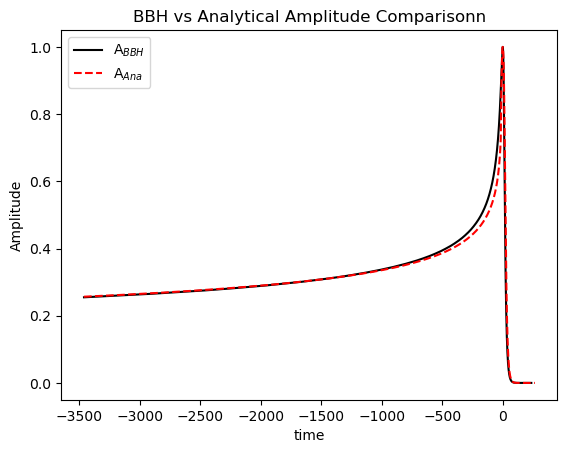

In [44]:
#reading the arrays separately
BBHTime = BBHAmp_raw[0,:]
BBHAmp = BBHAmp_raw[1,:]
BBHϕ = BBHϕ_raw[1,:]
BBHh22plus = BBHh22_raw[1,:]

#location of max SXS BBH amplitude
BBHAmax = np.max(BBHAmp)
i = 0
for i in range(len(BBHAmp)):
    if (BBHAmp[i] == BBHAmax):
        BBHiM = i
        break
#print(BBHiM, BBHTime[BBHiM]) 

#location of first SXS point, tuned to the Analytic BBH start time location        
for i in range(len(BBHTime)):
    if (0.9998 < BBHTime[i]/MtarrhybM[0] < 1.0001):
        BBHti0 = i
print("initial time, match in initial time",BBHti0, BBHTime[BBHti0], MtarrhybM[0])


#location of first SXS point, tuned to the Analytic BBH start frequency location        
#calculating the BBH frequency
BBHω=np.gradient(BBHϕ,BBHTime)
for i in range(len(BBHTime)):
    if (0.9999 < BBHω[i]/Mωhybarr[0] < 1.0001):
        BBHωi0 = i
print("initial time, match in initial freq",BBHωi0, BBHTime[BBHωi0], MtarrhybM[0])
print("initial freq, match in initial freq", BBHω[BBHωi0], Mωhybarr[0])
print("initial freq, match in initial time", BBHω[BBHti0], Mωhybarr[0])


#location of last SXS point        
BBHtF = BBHTime[-1]
BBHiF = len(BBHTime)-1
print(BBHTime[BBHti0], BBHTime[BBHωi0])
# pick the initial point for the SXS BBH array
BBHi0 =   BBHti0 #BBHωi0 
Δt0 = (BBHTime[BBHi0]- MtarrhybM[0])
# difference in amplitude at the initial time
BBHΔAmp = Amphybarr[0] - BBHAmp[BBHi0]
#print(BBHΔAmp, Δt0)
#plot the hybrid amplitude vs SXS
plt.title("BBH vs Analytical Amplitude Comparisonn")
plt.plot(BBHTime[BBHi0:BBHiF],BBHAmp[BBHi0:BBHiF], 'k')
plt.plot(MtarrhybM,Amphybarr, linestyle='dashed', color='red',linewidth=1.5)
#plt.plot(MtarrhybM,Amphybarr-BBHΔAmp, linestyle='dotted', color='blue',linewidth=1.5)
plt.xlabel("time")
plt.ylabel("Amplitude") 
plt.legend(("A$_{BBH}$","A$_{Ana}$"),loc="upper left")

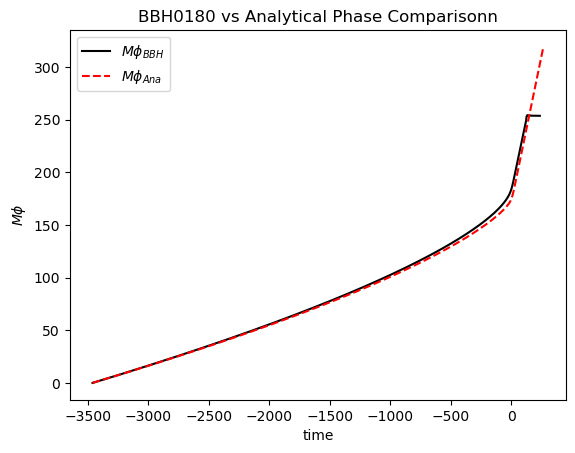

In [45]:
#compare the phases for SXS and analytical BBH
BBHΔϕ0 = Mϕhybarr[0] - BBHϕ[BBHi0] #phase difference at first point
BBHΔϕM = Mϕhybarr[numM] - BBHϕ[BBHiM] #phase difference at max aplitude

#plot the hybrid phase vs SXS
plt.title("BBH0180 vs Analytical Phase Comparisonn")
plt.plot(BBHTime[BBHi0:BBHiF],BBHϕ[BBHi0:BBHiF]-BBHϕ[BBHi0], 'k')
plt.plot(MtarrhybM,Mϕhybarr-Mϕhybarr[0], linestyle='dashed', color='red',linewidth=1.5)
#plt.plot(MtarrhybM,Mϕhybarr-BBHΔϕ0, linestyle='dotted', color='blue',linewidth=1.5)
plt.xlabel("time")
plt.ylabel("$M\phi$") 
plt.legend(("$M\phi_{BBH}$","$M\phi_{Ana}$"),loc="upper left")

0.0344265186329548 0.03482524366806212 -0.00039872503510731544


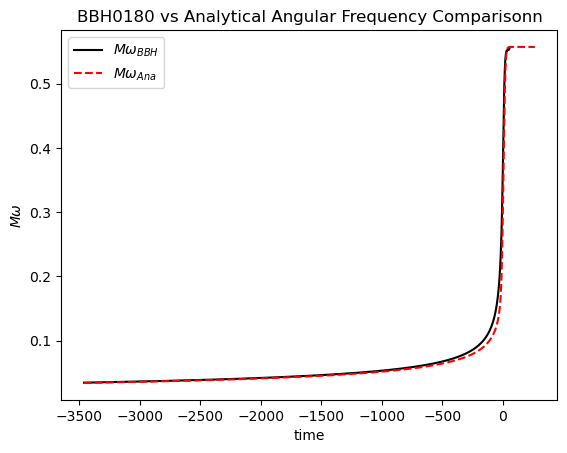

In [46]:
MωBBHarr=np.gradient(BBHϕ[BBHi0:BBHiF],BBHTime[BBHi0:BBHiF])
MωdotBBHarr=np.gradient(MωBBHarr,BBHTime[BBHi0:BBHiF])
BBHΔω0 = Mωhybarr[0] - MωBBHarr[0]
print(Mωhybarr[0], MωBBHarr[0], BBHΔω0)
#plot the hybrid angular frequency vs SXS
plt.title("BBH0180 vs Analytical Angular Frequency Comparisonn")
plt.plot(BBHTime[BBHi0:BBHiF-1800],MωBBHarr[0:-1800], 'k')
plt.plot(MtarrhybM,Mωhybarr, linestyle='dashed', color='red',linewidth=1.5)
plt.xlabel("time")
plt.ylabel("$M\omega$") 
plt.legend(("$M\omega_{BBH}$","$M\omega_{Ana}$"),loc="upper left")

0.4428040094244352


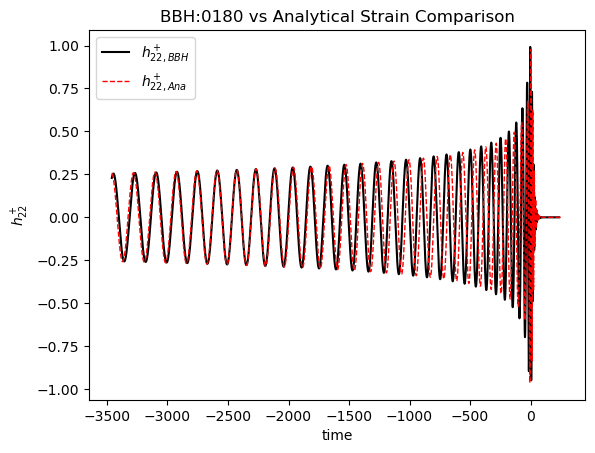

In [47]:
#compare the strains
BBHh22plus = BBHh22_raw[1,:]

#location of max SXS BBH strain
BBHh22max = np.max(abs(BBHh22plus))
i = 0
for i in range(len(BBHh22plus)):
    if (abs(BBHh22plus[i]) == BBHh22max):
        BBHh22iM = i
        break
NBBHh22plus = BBHh22plus/BBHh22max  
#print(BBHh22plus[BBHh22iM])

#location of max Analytic BBH strain
h22max = np.max(abs(hplushybarr))
i = 0
for i in range(len(MtarrhybM)):
    if (abs(hplushybarr[i]) == h22max):
        hybh22iM = i
        break
Nhplushybarr = hplushybarr/h22max
#print(hplushybarr[hybh22iM])

#print(BBHTime[BBHh22iM], MtarrhybM[hybh22iM])

#correct the amplitude and phase of the hybrid strain
#Amphybarrcorr = Amphybarr-BBHΔAmp
#Mϕhybarrcorr = Mϕhybarr-BBHΔϕ0
#form the corrected strain to plot
#hplushybarrcorr = np.array(hplushyb(Amphybarrcorr,Mϕhybarrcorr)).flatten()
#hcroshybarrcorr = np.array(hcroshyb(Amphybarrcorr,Mϕhybarrcorr)).flatten()

#plot the hybrid strain vs SXS
plt.title("BBH:0180 vs Analytical Strain Comparison")
#plt.plot(BBHTime[BBHi0:BBHiF]-Δt0,BBHh22plus[BBHi0:BBHiF], 'k')
plt.plot(BBHTime[BBHi0:BBHiF],BBHh22plus[BBHi0:BBHiF], 'k')
plt.plot(MtarrhybM, hplushybarr, linestyle='dashed', color='red',linewidth=1)
plt.xlabel("time")
plt.ylabel("$h^+_{22}$") 
plt.legend(("$h^+_{22,BBH}$","$h^+_{22,Ana}$"),loc="upper left")
print(Δt0)

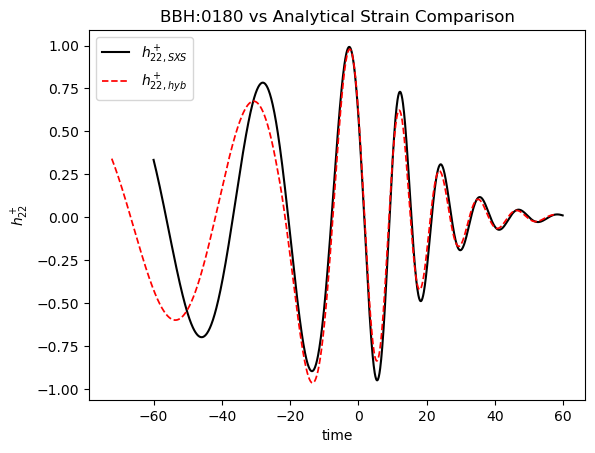

In [48]:
#plot the hybrid strain vs SXS around merger
plt.title("BBH:0180 vs Analytical Strain Comparison")
plt.plot(BBHTime[BBHiM-600:BBHiM+600], BBHh22plus[BBHiM-600:BBHiM+600], 'k')
#plt.plot(MtarrhybM[numM-2000:numM+1000], hplushybarrcorr[numM-2000:numM+1000], linestyle='dashed', color='red',linewidth=1.25)
plt.plot(MtarrhybM[numM-650:numM+650]-7.25,hplushybarr[numM-650:numM+650], linestyle='dashed', color='red',linewidth=1.25)
plt.xlabel("time")
plt.ylabel("$h^+_{22}$") 
plt.legend(("$h^+_{22,SXS}$","$h^+_{22,hyb}$"),loc="upper left")
#print(numM, len(MtarrhybM))

Note that the PN loses phase coherence around merger. For BoB  amplitude, one can take the integral, and then match, because BoB models $\Psi_4 = \ddot h$.

## Mass Rescaled Arrays for the BNS System
Remember that the BBH system is formed with the normalized mass. 
Now we must rescale the quantities affected by mass:
$$
\Omega_{BNS} = \Omega_{BBH}/m; ~~
\phi_{BNS} \rightarrow \phi_{BBH}/m; ~~
r_{BNS} \rightarrow m r_{BBH}; ~~
t_{BNS} \rightarrow m t_{BBH}.
$$

Observe also that the relationship between the initial separation and the collision time is:
$$
r_i \approx \left (\frac{64}{5}T_c \right )^{1/4}
$$
For a separation $r\approx 40$, we must rescale with the total mass $m = 2.8$ to obtain $r \approx 14$ and then calculate $T_c \approx \frac{5 r^4}{64}\approx 3221$. This is in agreement with the time array for SXS BNS, which confirms that the timearrays are already mass rescaled.  

In [49]:
#upload the SXS BNS0001 data, for G2 EOS
##maybe we must rescale the BNS by the masses???
m1 =2.8
m2 = 2.7
BNS1Amp_raw = np.genfromtxt('AmpBNS0001_raw.dat', unpack=True)
BNS1ϕ_raw = np.genfromtxt('ϕBNS0001_raw.dat', unpack=True)
BNS1h22_raw = np.genfromtxt('h22BNS0001_raw.dat', unpack=True)

#upload the SXS BNS0002 data, for MP1b EOS
BNS2Amp_raw = np.genfromtxt('AmpBNS0002_raw.dat', unpack=True)
BNS2ϕ_raw = np.genfromtxt('ϕBNS0002_raw.dat', unpack=True)
BNS2h22_raw = np.genfromtxt('h22BNS0002_raw.dat', unpack=True)

In [50]:
#reading the arrays separately for BNS1
BNS1Time = BNS1Amp_raw[0,:]
BNS1Amp = BNS1Amp_raw[1,:]
BNS1ϕ = BNS1ϕ_raw[1,:]
BNS1h22plus = BNS1h22_raw[1,:]

#readin the arrays separately for BNS2
BNS2Time = BNS2Amp_raw[0,:]
BNS2Amp = BNS2Amp_raw[1,:]
BNS2ϕ = BNS2ϕ_raw[1,:]
BNS2h22plus = BNS2h22_raw[1,:]

#correct the time arrays with reference time - where initial data error become insignificant
TrefBBH = 282
TrefBNS1 = 1195 #1278
TrefBNS2 = 985 # 959
print("initial phase", BNS1ϕ[0], BNS2ϕ[0], BBHϕ[0]) 
print("reference phase",BNS1ϕ[TrefBNS1], BNS2ϕ[TrefBNS2], BBHϕ[TrefBBH]) 

initial phase 1.7397480744694254 1.7548959249603577 1.6642915084435734
reference phase 15.81614783223061 15.367157076912793 9.373750538658298


In [51]:
#must find frequency at reference phase
def dfunO2(fip1, fim1, h):
    return (fip1 - fim1)/(2*h)

def dfunO4(fip2, fip1, fim1, fim2, h):    
    return (-fip2 + 8*fip1 - 8*fim1 + fim2)/(12*h)

h1 = (BNS1Time[TrefBNS1+1]-BNS1Time[TrefBNS1-1])/2
BNS1ωref_O2 = dfunO2(BNS1ϕ[TrefBNS1+1], BNS1ϕ[TrefBNS1-1], h1)
BNS1ωref_O4 = dfunO4(BNS1ϕ[TrefBNS1+2], BNS1ϕ[TrefBNS1+1], BNS1ϕ[TrefBNS1-1], BNS1ϕ[TrefBNS1-2],h1)
print("reference ω BNS1",BNS1ωref_O2, BNS1ωref_O4)

h2 = (BNS2Time[TrefBNS2+1]-BNS2Time[TrefBNS2-1])/2
BNS2ωref_O2 = dfunO2(BNS2ϕ[TrefBNS2+1], BNS2ϕ[TrefBNS2-1], h2)
BNS2ωref_O4 = dfunO4(BNS2ϕ[TrefBNS2+2], BNS2ϕ[TrefBNS2+1], BNS2ϕ[TrefBNS2-1], BNS2ϕ[TrefBNS2-2],h2)
print("reference ω BNS2",BNS2ωref_O2, BNS2ωref_O4,)

reference ω BNS1 0.03523340613296408 0.0352333494384628
reference ω BNS2 0.04076182896846302 0.0407617976423813


In [52]:
#BNS merge faster than BBH. 
#To plot the phase, must find the position where the frequencies are equal!

#location of matching frequencies  BBH SXS point, tuned to the BNS location        
for i in range(len(BBHω)):
    if (0.9999 < BBHω[i]/BNS1ωref_O4 < 1.001):
        BBH1ωiref = i
print(BBH1ωiref, BBHω[BBH1ωiref], BNS1ωref_O4)

for i in range(len(BBHω)):
    if (0.9999 < BBHω[i]/BNS2ωref_O4 < 1.001):
        BBH2ωiref = i
print(BBH2ωiref, BBHω[BBH2ωiref], BNS2ωref_O4)

5821 0.03526545964774641 0.0352333494384628
7274 0.04080062186872624 0.0407617976423813


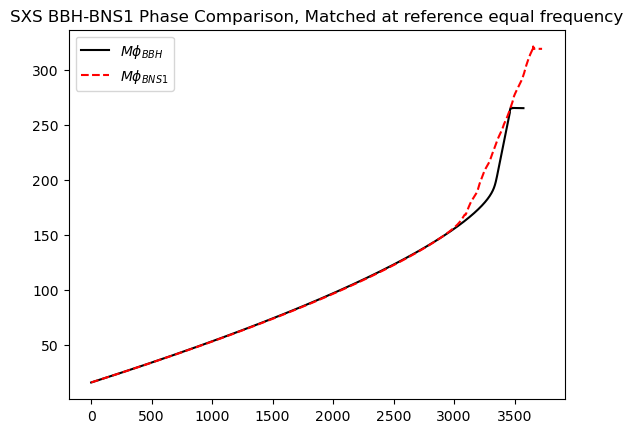

In [53]:
BBH1Δϕref = BBHϕ[BBH1ωiref] - BNS1ϕ[TrefBNS1]
plt.title("SXS BBH-BNS1 Phase Comparison, Matched at reference equal frequency")
plt.plot(BBHTime[BBH1ωiref:]-BBHTime[BBH1ωiref] ,BBHϕ[BBH1ωiref:]-BBH1Δϕref, 'k')
plt.plot(BNS1Time[TrefBNS1:]-BNS1Time[TrefBNS1] ,BNS1ϕ[TrefBNS1:], '--r')
plt.legend(("$M\phi_{BBH}$","$M\phi_{BNS1}$"),loc="upper left")

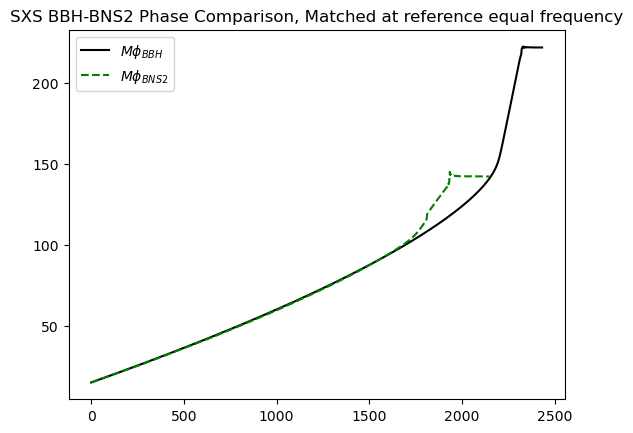

In [54]:
BBH2Δϕref = BBHϕ[BBH2ωiref] - BNS2ϕ[TrefBNS2]
plt.title("SXS BBH-BNS2 Phase Comparison, Matched at reference equal frequency")
plt.plot(BBHTime[BBH2ωiref:]-BBHTime[BBH2ωiref] ,BBHϕ[BBH2ωiref:]-BBH2Δϕref, 'k')
plt.plot(BNS2Time[TrefBNS2:]-BNS2Time[TrefBNS2] ,BNS2ϕ[TrefBNS2:], '--g')
plt.legend(("$M\phi_{BBH}$","$M\phi_{BNS2}$"),loc="upper left")

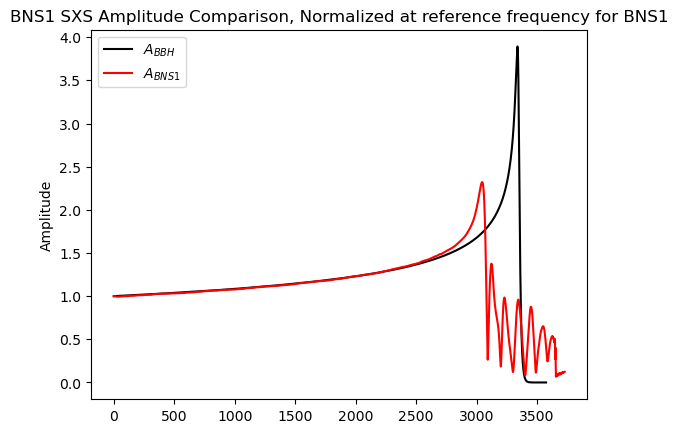

In [55]:
#scale the amplitudes with the reference phase amplitude of BBH
BNS1Ampref = BNS1Amp/BNS1Amp[TrefBNS1]
BBH1Ampωref = BBHAmp/BBHAmp[BBH1ωiref]

# plot the Amplitude BNS for SXS data normalized at reference frequency for BNS2
plt.title("BNS1 SXS Amplitude Comparison, Normalized at reference frequency for BNS1")
plt.plot(BBHTime[BBH1ωiref:] -BBHTime[BBH1ωiref],BBH1Ampωref[BBH1ωiref:], 'k')
plt.plot(BNS1Time[TrefBNS1:]-BNS1Time[TrefBNS1] ,BNS1Ampref[TrefBNS1:], 'r')
plt.ylabel("Amplitude") 
plt.legend(("$A_{BBH}$","$A_{BNS1}$"),loc="upper left")

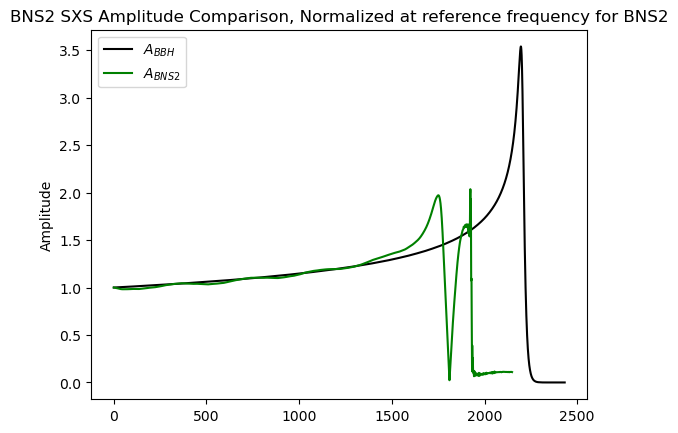

In [56]:
#scale the amplitudes with the reference phase amplitude of BBH
BNS2Ampref = BNS2Amp/BNS2Amp[TrefBNS2]
BBH2Ampωref = BBHAmp/BBHAmp[BBH2ωiref]

# plot the Amplitude BNS for SXS data normalized at reference frequency for BNS2
plt.title("BNS2 SXS Amplitude Comparison, Normalized at reference frequency for BNS2")
plt.plot(BBHTime[BBH2ωiref:] -BBHTime[BBH2ωiref],BBH2Ampωref[BBH2ωiref:], 'k')
plt.plot(BNS2Time[TrefBNS2:]-BNS2Time[TrefBNS2] ,BNS2Ampref[TrefBNS2:], 'g')
plt.ylabel("Amplitude") 
plt.legend(("$A_{BBH}$","$A_{BNS2}$"),loc="upper left")

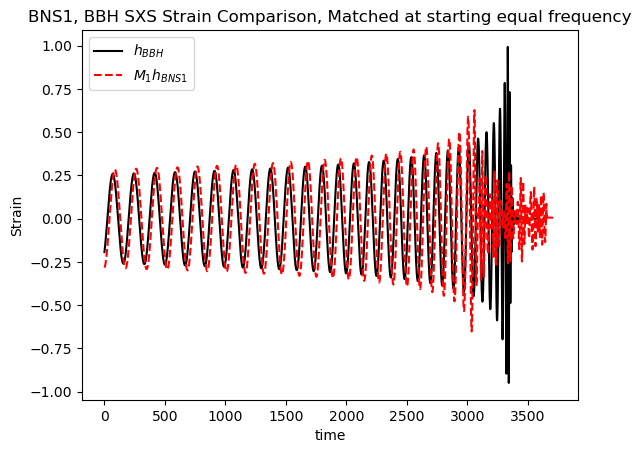

In [57]:
plt.title("BNS1, BBH SXS Strain Comparison, Matched at starting equal frequency")
plt.plot(BBHTime[BBH1ωiref:] - BBHTime[BBH1ωiref],BBHh22plus[BBH1ωiref:], 'k')
#plt.plot(BBHTime[BBH2ωiref:-1] - BBHTime[BBH2ωiref],BBHh22plus[BBH2ωiref:-1], 'k', linestyle='dashed')
plt.plot(BNS1Time[TrefBNS1:] - BNS1Time[TrefBNS1],m1*BNS1h22plus[TrefBNS1:], 'r', linestyle='dashed')
#plt.plot(BNS2Time[TrefBNS2:-1] - BNS2Time[TrefBNS2],m2*BNS2h22plus[TrefBNS2:-1], 'g', linestyle='dashed')
plt.xlabel("time")
plt.ylabel("Strain") 
plt.legend(("$h_{BBH}$","$M_1 h_{BNS1}$"),loc="upper left")

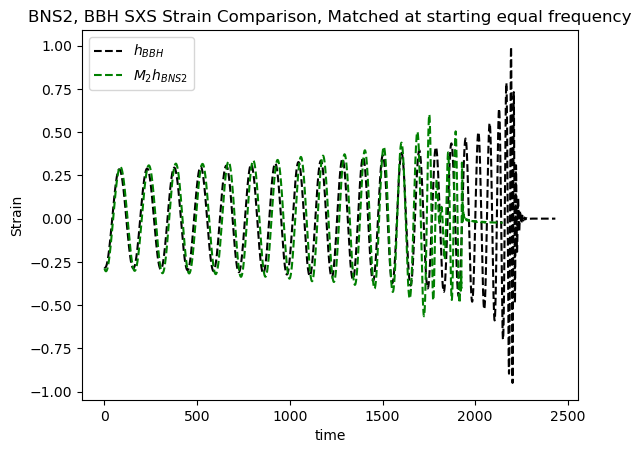

In [58]:
plt.title("BNS2, BBH SXS Strain Comparison, Matched at starting equal frequency")
#plt.plot(BBHTime[BBH1ωiref:-1] - BBHTime[BBH1ωiref],BBHh22plus[BBH1ωiref:-1], 'k')
plt.plot(BBHTime[BBH2ωiref:] - BBHTime[BBH2ωiref],BBHh22plus[BBH2ωiref:], 'k', linestyle='dashed')
#plt.plot(BNS1Time[TrefBNS1:-1] - BNS1Time[TrefBNS1],m1*BNS1h22plus[TrefBNS1:-1], 'r', linestyle='dashed')
plt.plot(BNS2Time[TrefBNS2:] - BNS2Time[TrefBNS2],m2*BNS2h22plus[TrefBNS2:], 'g', linestyle='dashed')
plt.xlabel("time")
plt.ylabel("Strain") 
plt.legend(("$h_{BBH}$","$M_2 h_{BNS2}$"),loc="upper left")

In [59]:
#location of matching frequencies  analytic BBH (point particle) point, tuned to the BNS location  

for i in range(len(Mϕhybarr)):
    if (0.9999 < Mωhybarr[i]/BNS1ωref_O4 < 1.0001):
        Mωhybiref_BBH1 = i

for i in range(len(Mϕhybarr)):
    if (0.9999 < Mωhybarr[i]/BNS2ωref_O4 < 1.0001):
        Mωhybiref_BBH2 = i

print("index of match point for BNS 1=",Mωhybiref_BBH1)
print("index of match point for BNS 2=", Mωhybiref_BBH2)

index of match point for BNS 1= 2279
index of match point for BNS 2= 13618


In [60]:
#Making arrays out of the releveant subsections of the BNS NR arrays for convienence
#will still need to "cut off" the ends of the arrays according to when our simulation ends
#phase array to match to BNS 1
MϕhybarrBNS1=Mϕhybarr[Mωhybiref_BBH1:]-Mϕhybarr[Mωhybiref_BBH1]
#Corresponding time array
MtarrhybBNS1=Mtarrhyb[Mωhybiref_BBH1:]-Mtarrhyb[Mωhybiref_BBH1]

NR1Time=BNS1Time[TrefBNS1:-1]-BNS1Time[TrefBNS1]
ϕNR1=BNS1ϕ[TrefBNS1:-1]-BNS1ϕ[TrefBNS1]

#phase array to match to BNS 2
MϕhybarrBNS2=Mϕhybarr[Mωhybiref_BBH2:]-Mϕhybarr[Mωhybiref_BBH2]
#Corresponding time array
MtarrhybBNS2=Mtarrhyb[Mωhybiref_BBH2:]-Mtarrhyb[Mωhybiref_BBH2]

NR2Time=BNS2Time[TrefBNS2:-1]-BNS2Time[TrefBNS2]
ϕNR2=BNS2ϕ[TrefBNS2:-1]-BNS2ϕ[TrefBNS2]

#plt.plot(NR1Time,ϕNR1)
#plt.plot(NR2Time,ϕNR2)
#plt.plot(MtarrhybBNS1,MϕhybarrBNS1)
#plt.plot(MtarrhybBNS2,MϕhybarrBNS2)

In [61]:
#We must form the time arrays to match with the analytical BBH. 
#print("Analytic BBH and SXS BBH start time", MtarrhybM[0], BBHi0, BBHTime[BBHi0])
#print("SXS BBH BNS1 time", BBH1ωiref, BBHTime[BBH1ωiref])
#print("SXS BBH BNS2 time", BBH2ωiref, BBHTime[BBH2ωiref])

#find the time array in the Analytic BBH corresponding to the BNS frequency, two ways:
#location of first Analytic point, tuned to the BNS1 ref location        
for i in range(len(MtarrhybM)):
    if (0.9999 < MtarrhybM[i]/BBHTime[BBH1ωiref] < 1.0001):
        numtBNS1ref = i
for i in range(len(Mωhybarr)):
    if (0.9999 < Mωhybarr[i]/BNS1ωref_O4 < 1.0001):
        numωBNS1ref = i
#print("indice analytic time array", numtBNS1ref, numωBNS1ref)        
#print("initial analytic time for BNS 1",MtarrhybM[numtBNS1ref], MtarrhybM[numωBNS1ref], BBHTime[BBH1ωiref])
#print("initial analytic ω for BNS 1",Mωhybarr[numtBNS1ref], Mωhybarr[numωBNS1ref], BNS1ωref_O4)

#location of first Analytic point, tuned to the BNS2 ref location        
for i in range(len(MtarrhybM)):
    if (0.9999 < MtarrhybM[i]/BBHTime[BBH2ωiref] < 1.0001):
        numtBNS2ref = i
for i in range(len(Mωhybarr)):
    if (0.9999 < Mωhybarr[i]/BNS2ωref_O4 < 1.0001):
        numωBNS2ref = i
        
# the time match is better, there is a time mismatch between analytic and NR time arrays
numBNS1ref = numtBNS1ref
numBNS2ref = numtBNS2ref 
#print("indice analytic time array", numtBNS2ref, numωBNS2ref)        
#print("initial analytic time for BNS 2",MtarrhybM[numtBNS2ref], MtarrhybM[numωBNS2ref], BBHTime[BBH2ωiref])
#print("initial analytic ω for BNS 2",Mωhybarr[numtBNS2ref], Mωhybarr[numωBNS2ref], BNS2ωref_O4)

#print(numωBNS1ref, numωBNS2ref)
#print("index of match point for BNS 1=",Mωhybiref_BBH1)
#print("index of match point for BNS 2=", Mωhybiref_BBH2)

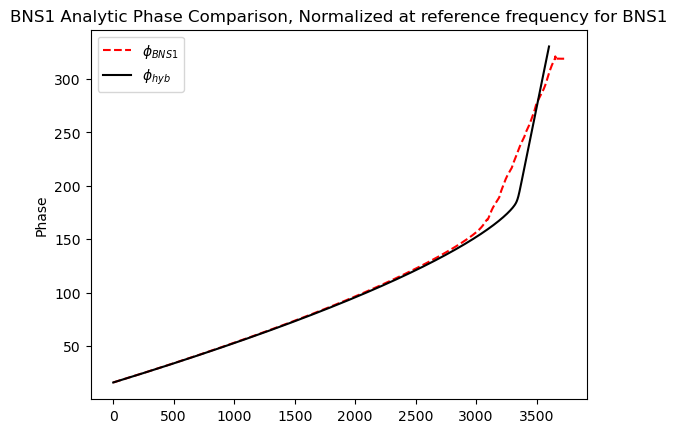

In [62]:
#scale the phase with the reference phase amplitude of BBH
# plot the Phase BNS for SXS data normalized at reference frequency for BNS2
Ana1Δϕref = Mϕhybarr[numBNS1ref] - BNS1ϕ[TrefBNS1]
#Ana1Δϕωref = Mϕhybarr[numωBNS1ref] - BNS1ϕ[TrefBNS1]
plt.title("BNS1 Analytic Phase Comparison, Normalized at reference frequency for BNS1")
plt.plot(BNS1Time[TrefBNS1:-1]-BNS1Time[TrefBNS1] ,BNS1ϕ[TrefBNS1:-1], '--r')
plt.plot(MtarrhybM[numBNS1ref:-1] -MtarrhybM[numBNS1ref],Mϕhybarr[numBNS1ref:-1]-Ana1Δϕref, 'k')
#plt.plot(MtarrhybM[numωBNS1ref:-1] -MtarrhybM[numωBNS1ref],Mϕhybarr[numωBNS1ref:-1]-Ana1Δϕωref, '--k')
#plt.plot(BBHTime[BBH1ωiref:-1]-BBHTime[BBH1ωiref] ,BBHϕ[BBH1ωiref:-1]-BBH1Δϕref, 'b')
plt.ylabel("Phase") 
plt.legend(("$\phi_{BNS1}$", "$\phi_{hyb}$"),loc="upper left")

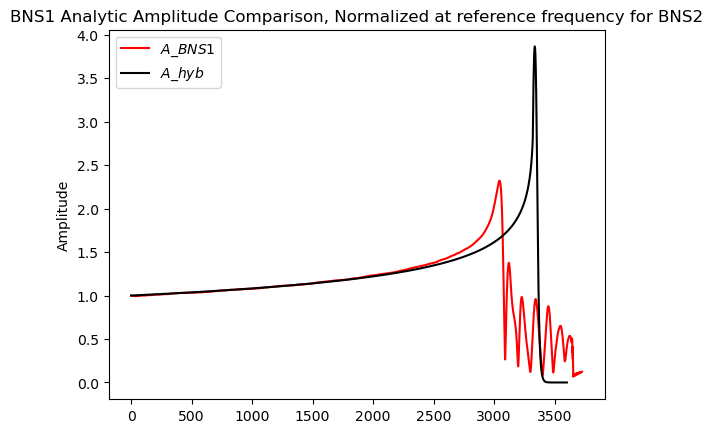

In [63]:
#scale the amplitudes with the reference phase amplitude of BBH
Amphyb1ref = Amphybarr/Amphybarr[numBNS1ref]
#Amphyb1ωref = Amphybarr/Amphybarr[numωBNS1ref]

# plot the Amplitude BNS for SXS data normalized at reference frequency for BNS2
plt.title("BNS1 Analytic Amplitude Comparison, Normalized at reference frequency for BNS2")
plt.plot(BNS1Time[TrefBNS1:-1]-BNS1Time[TrefBNS1] ,BNS1Ampref[TrefBNS1:-1], 'r')
plt.plot(MtarrhybM[numBNS1ref:-1] -MtarrhybM[numBNS1ref],Amphyb1ref[numBNS1ref:-1], 'k')
#plt.plot(MtarrhybM[numωBNS1ref:-1] -MtarrhybM[numωBNS1ref],Amphyb1ωref[numωBNS1ref:-1], '--k')
plt.ylabel("Amplitude") 
plt.legend(("$A\_{BNS1}$", "$A\_{hyb}$"),loc="upper left")

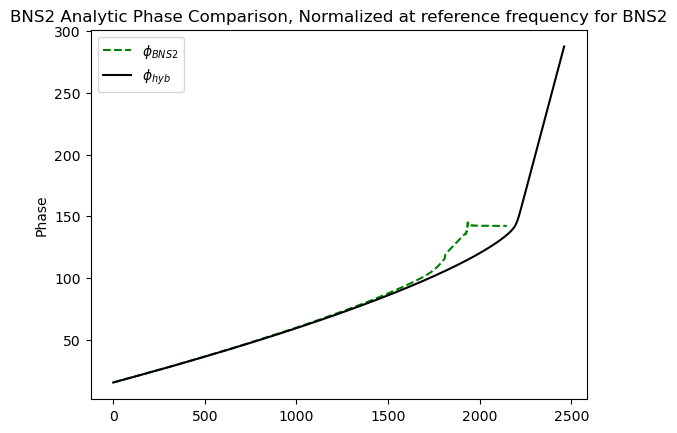

In [64]:
#scale the phase with the reference phase amplitude of BBH
# plot the Phase BNS for SXS data normalized at reference frequency for BNS2
Ana2Δϕref = Mϕhybarr[numBNS2ref] - BNS2ϕ[TrefBNS2]
#Ana2Δϕωref = Mϕhybarr[numωBNS2ref] - BNS2ϕ[TrefBNS2]

plt.title("BNS2 Analytic Phase Comparison, Normalized at reference frequency for BNS2")
plt.plot(BNS2Time[TrefBNS2:-1]-BNS2Time[TrefBNS2] ,BNS2ϕ[TrefBNS2:-1], '--g')
plt.plot(MtarrhybM[numBNS2ref:-1] -MtarrhybM[numBNS2ref],Mϕhybarr[numBNS2ref:-1]-Ana2Δϕref, 'k')
#plt.plot(MtarrhybM[numωBNS2ref:-1] -MtarrhybM[numωBNS2ref],Mϕhybarr[numωBNS2ref:-1]-Ana2Δϕωref, '--k')
plt.ylabel("Phase") 
plt.legend(("$\phi_{BNS2}$", "$\phi_{hyb}$"),loc="upper left")

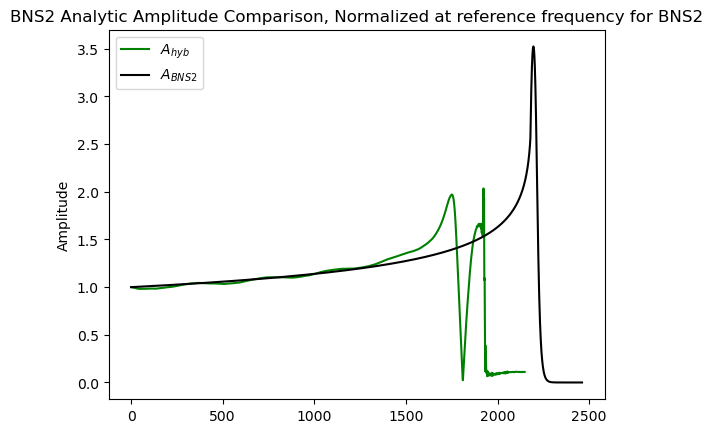

In [65]:
#scale the amplitudes with the reference phase amplitude of BBH
Amphyb2ref = Amphybarr/Amphybarr[numBNS2ref]
#Amphyb2ωref = Amphybarr/Amphybarr[numωBNS2ref]

# plot the Amplitude BNS for SXS data normalized at reference frequency for BNS2
plt.title("BNS2 Analytic Amplitude Comparison, Normalized at reference frequency for BNS2")
plt.plot(BNS2Time[TrefBNS2:-1]-BNS2Time[TrefBNS2] ,BNS2Ampref[TrefBNS2:-1], 'g')
plt.plot(MtarrhybM[numBNS2ref:-1] -MtarrhybM[numBNS2ref],Amphyb2ref[numBNS2ref:-1], 'k')
#plt.plot(MtarrhybM[numωBNS2ref:-1] -MtarrhybM[numωBNS2ref],Amphyb2ωref[numωBNS2ref:-1], '--k')
plt.ylabel("Amplitude") 
plt.legend(("$A_{hyb}$","$A_{BNS2}$"),loc="upper left")

In [66]:
#it's time to find the last point of the BNS time array
#print(BBHTime[BBH1ωiref]-BBHTime[BBH1ωiref], BBHTime[-1]-BBHTime[BBH1ωiref])
#print(BNS1Time[TrefBNS1]-BNS1Time[TrefBNS1], BNS1Time[-1]-BNS1Time[TrefBNS1])
# note that the final BBH time is smaller than the final BNS1 time. Should stop there!
for i in range(len(BNS1Time)):    
    if (0.9999 < (BNS1Time[i]-BNS1Time[TrefBNS1])/(BBHTime[-1]-BBHTime[BBH1ωiref]) < 1.0001):
        TfinBNS1 = i

#equally spaced time array for BNS1 interpolation
# BNS1Time[TrefBNS1:TfinBNS1]; MtarrhybM[numωBNS1ref:], BBHTime[BBH1ωiref:]
BNS1T0 = BNS1Time[TrefBNS1]
BNS1Tf = BNS1Time[TfinBNS1] 
BNS1Tarr = np.arange(BNS1T0,BNS1Tf+dt, dt, dtype=np.float64)
print("BNS1:",BNS1Tf - BNS1T0, len(BNS1Tarr))

#equally spaced time array for BNS1 interpolation
# BNS2Time[TrefBNS2:-1]; MtarrhybM[numωBNS2ref:], BBHTime[BBH2ωiref:]
BNS2T0 = BNS2Time[TrefBNS2]
BNS2Tf = BNS2Time[-1] 
BNS2Tarr = np.arange(BNS2T0,BNS2Tf, dt, dtype=np.float64)
print("BNS2:",BNS2Tf - BNS2T0, len(BNS2Tarr))

# note that the final BNS1 time is smaller than the final BBH time. Should stop there!
for i in range(len(BBHTime)):    
    if (0.9999 < (BBHTime[i]-BBHTime[BBH2ωiref])/(BNS2Time[-1]-BNS2Time[TrefBNS2]) < 1.0001):
        TfinBBH2 = i
print("BBH2:", BBHTime[TfinBBH2]-BBHTime[BBH2ωiref],len(BBHTime[BBH2ωiref:TfinBBH2]))

BNS1: 3573.818161182085 35740
BNS2: 2148.400683367835 21485
BBH2: 2148.5243318819985 9181


In [67]:
#fitted arrays
#time arrays for BNS1 interpolation
BBH1Tarr = np.zeros(len(BNS1Tarr))
p=0
for e in range(len(BNS1Tarr)):
    BBH1Tarr[p]=BBHTime[BBH1ωiref]+p*dt
    p=p+1
print(BBH1Tarr[-1] - BBH1Tarr[0], len(BBH1Tarr))
    
AnaBBH1Tarr = np.zeros(len(BNS1Tarr))
p=0
for e in range(len(BNS1Tarr)):
    AnaBBH1Tarr[p] = MtarrhybM[numBNS1ref]+p*dt
    p=p+1
print(AnaBBH1Tarr[-1] - AnaBBH1Tarr[0], len(AnaBBH1Tarr))

#time arrays for BNS2 interpolation
BBH2Tarr = np.zeros(len(BNS2Tarr))
p=0
for e in range(len(BNS2Tarr)):
    BBH2Tarr[p]=BBHTime[BBH2ωiref]+p*dt
    p=p+1
print(BBH2Tarr[-1] - BBH2Tarr[0], len(BBH2Tarr))
    
AnaBBH2Tarr = np.zeros(len(BNS2Tarr))
p=0
for e in range(len(BNS2Tarr)):
    AnaBBH2Tarr[p] = MtarrhybM[numBNS2ref]+p*dt
    p=p+1
print(AnaBBH2Tarr[-1] - AnaBBH2Tarr[0], len(AnaBBH2Tarr))


##create a shifted time array just for convenience in plotting: 
BNS1Tshift = np.zeros(len(BNS1Tarr))
p=0
for e in range(len(BNS1Tarr)):
    BNS1Tshift[p]=BNS1Tarr[e] - BNS1Tarr[0]
    p=p+1
    
BNS2Tshift = np.zeros(len(BNS2Tarr))
p=0
for e in range(len(BNS2Tarr)):
    BNS2Tshift[p]=BNS2Tarr[e] - BNS2Tarr[0]
    p=p+1
    
print("length of arrays for BNS1",len(BNS1Tarr), len(BBH1Tarr), len(AnaBBH1Tarr), len(BNS1Tshift))
print("length of arrays for BNS2",len(BNS2Tarr), len(BBH2Tarr), len(AnaBBH2Tarr), len(BNS2Tshift))

3573.9 35740
3573.9 35740
2148.4 21485
2148.4 21485
length of arrays for BNS1 35740 35740 35740 35740
length of arrays for BNS2 21485 21485 21485 21485


35740


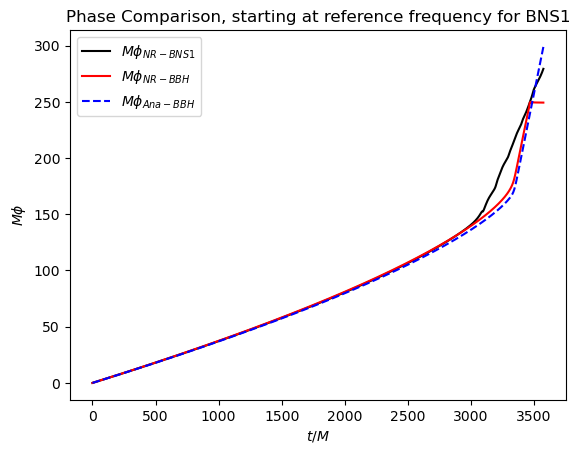

In [68]:
#now that we painstakely built the arrays, let's interpolate
#time arrays for BNS1 interpolation
BNS1ϕint = interp1d(BNS1Time[TrefBNS1:TfinBNS1],BNS1ϕ[TrefBNS1:TfinBNS1], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BNS1ϕintarr = np.array(BNS1ϕint(BNS1Tarr)).flatten()
#plt.plot(BNS1Tarr, BNS1ϕintarr, 'k')

BBH1ϕint = interp1d(BBHTime[BBH1ωiref:-1],BBHϕ[BBH1ωiref:-1], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BBH1ϕintarr = np.array(BBH1ϕint(BBH1Tarr)).flatten()
#plt.plot(BBH1Tarr, BBH1ϕintarr, 'k')

numBNS1fin = len(AnaBBH1Tarr)+numBNS1ref
print(len(MtarrhybM[numBNS1ref:numBNS1fin]))
AnaBBH1ϕint = interp1d(MtarrhybM[numBNS1ref:numBNS1fin], Mϕhybarr[numBNS1ref:numBNS1fin], bounds_error=False, fill_value="extrapolate",kind = "cubic")
AnaBBH1ϕintarr = np.array(AnaBBH1ϕint(AnaBBH1Tarr)).flatten()
#plt.plot(AnaBBH1Tarr, AnaBBH1ϕintarr, 'k')

plt.title("Phase Comparison, starting at reference frequency for BNS1")
plt.plot(BNS1Tshift, BNS1ϕintarr-BNS1ϕintarr[0], 'k')
plt.plot(BNS1Tshift, BBH1ϕintarr-BBH1ϕintarr[0], '-r')
plt.plot(BNS1Tshift, AnaBBH1ϕintarr-AnaBBH1ϕintarr[0], '--b')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi$") 
plt.legend(("$M\phi_{NR-BNS1}$", "$M\phi_{NR-BBH}$", "$M\phi_{Ana-BBH}$"),loc="upper left")

21485


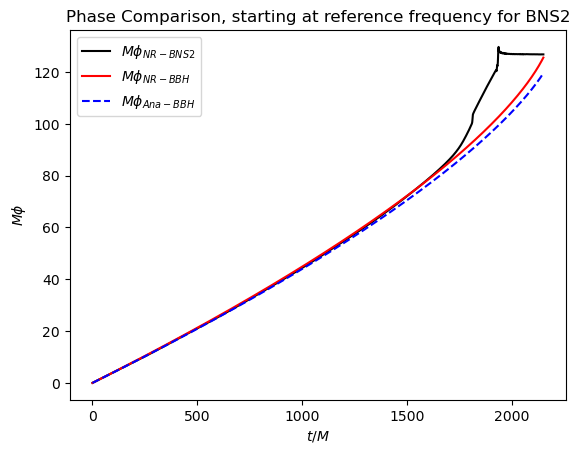

In [69]:
#now that we painstakely built the arrays, let's interpolate
#time arrays for BNS2 interpolation
BNS2ϕint = interp1d(BNS2Time[TrefBNS2:-1],BNS2ϕ[TrefBNS2:-1], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BNS2ϕintarr = np.array(BNS2ϕint(BNS2Tarr)).flatten()
#plt.plot(BNS2Tarr, BNS2ϕintarr, 'k')

BBH2ϕint = interp1d(BBHTime[BBH2ωiref:TfinBBH2],BBHϕ[BBH2ωiref:TfinBBH2], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BBH2ϕintarr = np.array(BBH2ϕint(BBH2Tarr)).flatten()
#plt.plot(BBH1Tarr, BBH1ϕintarr, 'k')

numBNS2fin = len(AnaBBH2Tarr)+numBNS2ref
print(len(MtarrhybM[numBNS2ref:numBNS2fin]))
AnaBBH2ϕint = interp1d(MtarrhybM[numBNS2ref:numBNS2fin], Mϕhybarr[numBNS2ref:numBNS2fin], bounds_error=False, fill_value="extrapolate",kind = "cubic")
AnaBBH2ϕintarr = np.array(AnaBBH2ϕint(AnaBBH2Tarr)).flatten()
#plt.plot(AnaBBH2Tarr, AnaBBH2ϕintarr, 'k')

plt.title("Phase Comparison, starting at reference frequency for BNS2")
plt.plot(BNS2Tshift, BNS2ϕintarr-BNS2ϕintarr[0], 'k')
plt.plot(BNS2Tshift, BBH2ϕintarr-BBH2ϕintarr[0], '-r')
plt.plot(BNS2Tshift, AnaBBH2ϕintarr-AnaBBH2ϕintarr[0], '--b')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi$") 
plt.legend(("$M\phi_{NR-BNS2}$", "$M\phi_{NR-BBH}$", "$M\phi_{Ana-BBH}$"),loc="upper left")

In [70]:
print(BNS1Time[TrefBNS1],BNS2Time[TrefBNS2])
ΔTrefBNS12 = (BNS2Time[TrefBNS2]-BNS1Time[TrefBNS1])
ΔϕrefBNS12 = BBHϕ[BBH2ωiref]-BBHϕ[BBH1ωiref]
print(ΔTrefBNS12,ΔϕrefBNS12)

-3045.1591896821205 -1923.4295076948094
1121.729681987311 43.11353796457786


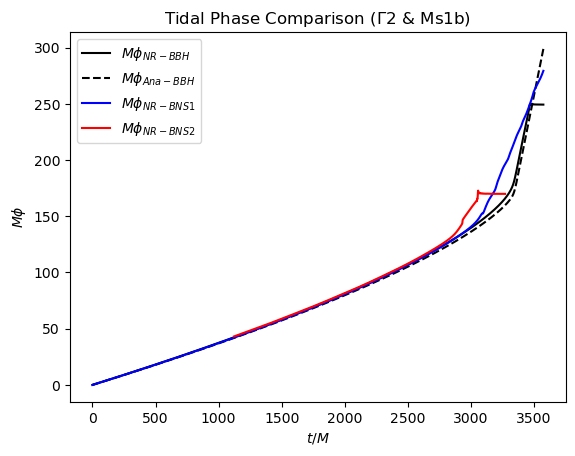

In [71]:
# plot the Phase Difference BNS matched at start 
plt.title("Tidal Phase Comparison ($\Gamma$2 & Ms1b)")
plt.plot(BNS1Tshift, BBH1ϕintarr-BBH1ϕintarr[0], 'k')
plt.plot(BNS1Tshift, AnaBBH1ϕintarr-AnaBBH1ϕintarr[0], '--k')
plt.plot(BNS1Tshift, BNS1ϕintarr-BNS1ϕintarr[0], 'b')
plt.plot(BNS2Tshift+ΔTrefBNS12, BNS2ϕintarr-BNS2ϕintarr[0]+ΔϕrefBNS12, 'r')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi$") 
plt.legend(("$M\phi_{NR-BBH}$","$M\phi_{Ana-BBH}$", "$M\phi_{NR-BNS1}$", "$M\phi_{NR-BNS2}$"),loc="upper left")

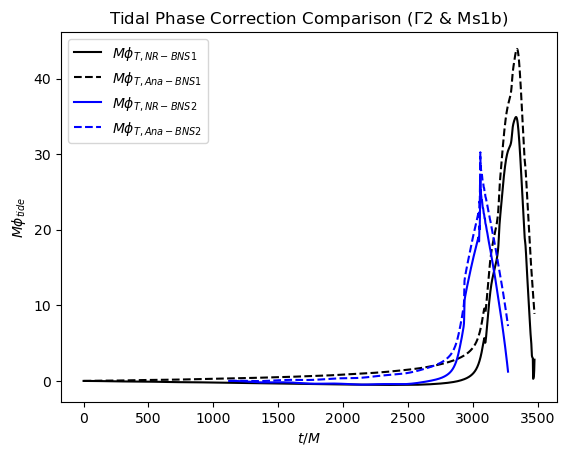

In [72]:
# now we can take the differences between the phases to find the tidal correction
BNS1ϕTideNR = (BNS1ϕintarr-BNS1ϕintarr[0])-(BBH1ϕintarr-BBH1ϕintarr[0])
BNS1ϕTideAna = (BNS1ϕintarr-BNS1ϕintarr[0])-(AnaBBH1ϕintarr-AnaBBH1ϕintarr[0])

BNS2ϕTideNR = (BNS2ϕintarr-BNS2ϕintarr[0])-(BBH2ϕintarr-BBH2ϕintarr[0])
BNS2ϕTideAna = (BNS2ϕintarr-BNS2ϕintarr[0])-(AnaBBH2ϕintarr-AnaBBH2ϕintarr[0])


# plot the Phase Difference BNS matched at start 
plt.title("Tidal Phase Correction Comparison ($\Gamma$2 & Ms1b)")
plt.plot(BNS1Tshift[0:-1000], BNS1ϕTideNR[0:-1000], 'k')
plt.plot(BNS1Tshift[0:-1000], BNS1ϕTideAna[0:-1000], '--k')
plt.plot(BNS2Tshift+ΔTrefBNS12, BNS2ϕTideNR, 'b')
plt.plot(BNS2Tshift+ΔTrefBNS12, BNS2ϕTideAna, '--b')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{tide}$") 
plt.legend(("$M\phi_{T,NR-BNS1}$", "$M\phi_{T,Ana-BNS1}$", "$M\phi_{T,NR-BNS2}$", "$M\phi_{T,Ana-BNS2}$"),loc="upper left")

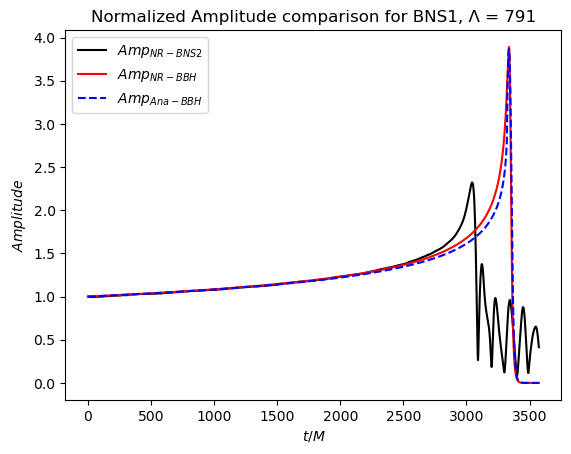

In [73]:
#repeat the procedure for amplitudes
#time arrays for BNS1 interpolation
BBH1Ampint = interp1d(BBHTime[BBH1ωiref:-1],BBHAmp[BBH1ωiref:-1], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BBH1Ampintarr = np.array(BBH1Ampint(BBH1Tarr)).flatten()
#plt.plot(BBH1Tarr, BBH1ϕintarr, 'k')

BNS1Ampint = interp1d(BNS1Time[TrefBNS1:TfinBNS1],BNS1Amp[TrefBNS1:TfinBNS1], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BNS1Ampintarr = np.array(BNS1Ampint(BNS1Tarr)).flatten()
#plt.plot(BNS1Tarr, BNS1ϕintarr, 'k')

AnaBBH1Aint = interp1d(MtarrhybM[numBNS1ref:numBNS1fin], Amphybarr[numBNS1ref:numBNS1fin], bounds_error=False, fill_value="extrapolate",kind = "cubic")
AnaBBH1Aintarr = np.array(AnaBBH1Aint(AnaBBH1Tarr)).flatten()
#plt.plot(AnaBBH1Tarr, AnaBBH1ϕintarr, 'k')

plt.title("Normalized Amplitude comparison for BNS1, Λ = 791")
plt.plot(BNS1Tshift, BNS1Ampintarr/BNS1Ampintarr[0], 'k')
plt.plot(BNS1Tshift, BBH1Ampintarr/BBH1Ampintarr[0], '-r')
plt.plot(BNS1Tshift, AnaBBH1Aintarr/AnaBBH1Aintarr[0], '--b')
plt.xlabel("$t/M$")
plt.ylabel("$Amplitude$") 
plt.legend(("$Amp_{NR-BNS2}$", "$Amp_{NR-BBH}$", "$Amp_{Ana-BBH}$"),loc="upper left")

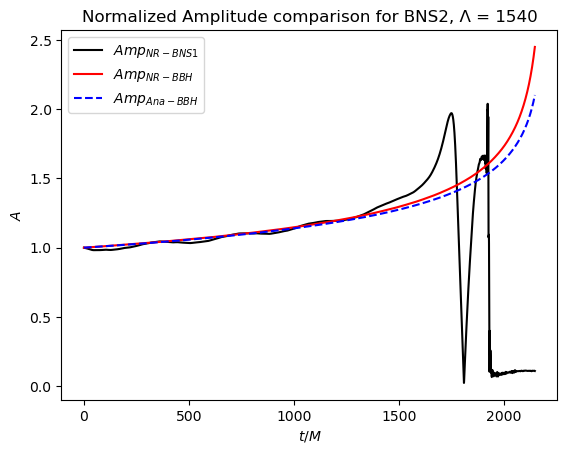

In [74]:
#repeat the procedure for amplitudes
#time arrays for BNS2 interpolation
BBH2Ampint = interp1d(BBHTime[BBH2ωiref:TfinBBH2],BBHAmp[BBH2ωiref:TfinBBH2], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BBH2Ampintarr = np.array(BBH2Ampint(BBH2Tarr)).flatten()
#plt.plot(BBH1Tarr, BBH1ϕintarr, 'k')

BNS2Ampint = interp1d(BNS2Time[TrefBNS2:-1],BNS2Amp[TrefBNS2:-1], bounds_error=False, fill_value="extrapolate",kind = "cubic")
BNS2Ampintarr = np.array(BNS2Ampint(BNS2Tarr)).flatten()
#plt.plot(BNS1Tarr, BNS1ϕintarr, 'k')

AnaBBH2Aint = interp1d(MtarrhybM[numBNS2ref:numBNS2fin], Amphybarr[numBNS2ref:numBNS2fin], bounds_error=False, fill_value="extrapolate",kind = "cubic")
AnaBBH2Aintarr = np.array(AnaBBH2Aint(AnaBBH2Tarr)).flatten()
#plt.plot(AnaBBH1Tarr, AnaBBH1ϕintarr, 'k')


plt.title("Normalized Amplitude comparison for BNS2, Λ = 1540")
plt.plot(BNS2Tshift, BNS2Ampintarr/BNS2Ampintarr[0], 'k')
plt.plot(BNS2Tshift, BBH2Ampintarr/BBH2Ampintarr[0], '-r')
plt.plot(BNS2Tshift, AnaBBH2Aintarr/AnaBBH2Aintarr[0], '--b')
plt.xlabel("$t/M$")
plt.ylabel("$A$") 
plt.legend(("$Amp_{NR-BNS1}$", "$Amp_{NR-BBH}$", "$Amp_{Ana-BBH}$"),loc="upper left")

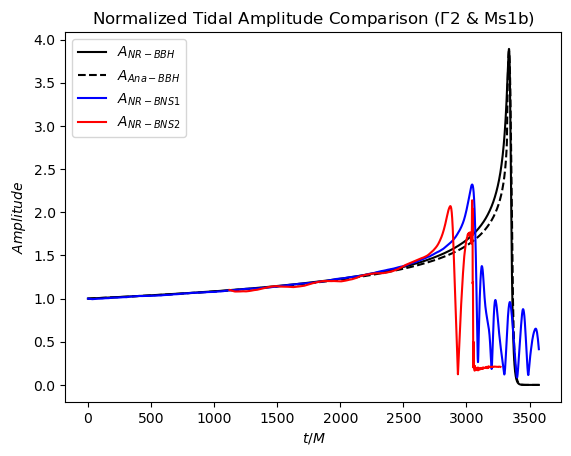

In [75]:
ΔArefBNS12 = (BBHAmp[BBH2ωiref]-BBHAmp[BBH1ωiref])/BBH1Ampintarr[0]
# plot the Phase Difference BNS matched at start 
plt.title("Normalized Tidal Amplitude Comparison ($\Gamma$2 & Ms1b)")
plt.plot(BNS1Tshift, BBH1Ampintarr/BBH1Ampintarr[0], 'k')
plt.plot(BNS1Tshift, AnaBBH1Aintarr/AnaBBH1Aintarr[0], '--k')
plt.plot(BNS1Tshift, BNS1Ampintarr/BNS1Ampintarr[0], 'b')
plt.plot(BNS2Tshift+ΔTrefBNS12, BNS2Ampintarr/BNS2Ampintarr[0]+ΔArefBNS12, 'r')
plt.xlabel("$t/M$")
plt.ylabel("$Amplitude$") 
plt.legend(("$A_{NR-BBH}$","$A_{Ana-BBH}$", "$A_{NR-BNS1}$", "$A_{NR-BNS2}$"),loc="upper left")

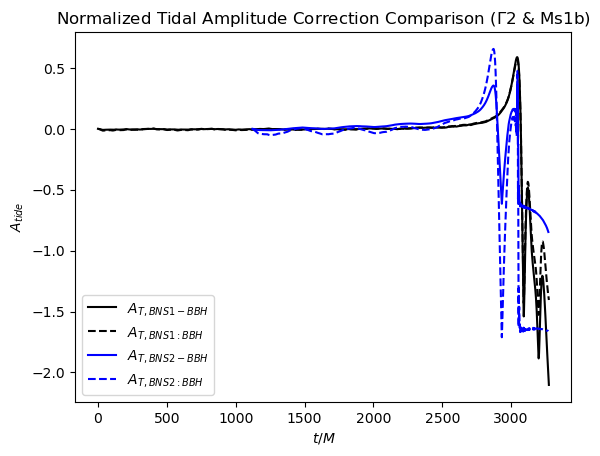

In [76]:
# now we can take the differences between the phases to find the tidal correction
BNS1AmpTideNR = (BNS1Ampintarr/BNS1Ampintarr[0])-(BBH1Ampintarr/BBH1Ampintarr[0])
BNS1AmpTideAna = (BNS1Ampintarr/BNS1Ampintarr[0])-(AnaBBH1Aintarr/AnaBBH1Aintarr[0])

BNS2AmpTideNR = (BNS2Ampintarr-BNS2Ampintarr[0])-(BBH2Ampintarr-BBH2Ampintarr[0])
BNS2AmpTideAna = (BNS2Ampintarr-BNS2Ampintarr[0])-(AnaBBH2Aintarr-AnaBBH2Aintarr[0])

BNS1AmpRatioTideNR = (BNS1Ampintarr)/(BBH1Ampintarr)-(BNS1Ampintarr[0])/(BBH1Ampintarr[0])
BNS1AmpRatioTideAna = (BNS1Ampintarr)/(AnaBBH1Aintarr)-(BNS1Ampintarr[0])/(AnaBBH1Aintarr[0])

BNS2AmpRatioTideNR = (BNS2Ampintarr)/(BBH2Ampintarr)- (BNS2Ampintarr[0])/(BBH2Ampintarr[0])
BNS2AmpRatioTideAna = (BNS2Ampintarr)/(AnaBBH2Aintarr)-(BNS2Ampintarr[0])/(AnaBBH2Aintarr[0])

# plot the Phase Difference BNS matched at start 
plt.title("Normalized Tidal Amplitude Correction Comparison ($\Gamma$2 & Ms1b)")
plt.plot(BNS1Tshift[0:-3000], BNS1AmpTideNR[0:-3000], 'k')
plt.plot(BNS1Tshift[0:-3000], BNS1AmpRatioTideNR[0:-3000], '--k')
plt.plot(BNS2Tshift+ΔTrefBNS12, BNS2AmpTideNR, 'b')
plt.plot(BNS2Tshift+ΔTrefBNS12, BNS2AmpRatioTideNR, '--b')
plt.xlabel("$t/M$")
plt.ylabel("$A_{tide}$") 
plt.legend(("$A_{T,BNS1-BBH}$", "$A_{T,BNS1:BBH}$", "$A_{T,BNS2-BBH}$", "$A_{T,BNS2 : BBH}$"),loc="lower left")

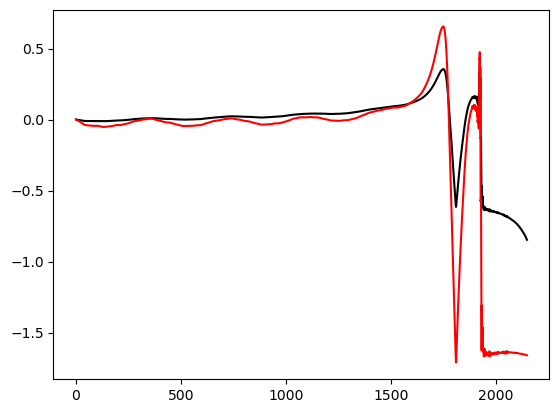

In [77]:
plt.plot(BNS2Tshift, BNS2AmpTideNR, 'k')
#plt.plot(BNS2Tshift, BNS2AmpRatioTideNR, 'b')
plt.plot(BNS2Tshift, BNS2AmpRatioTideNR-BNS2AmpRatioTideNR[0], 'r')

In [78]:
#find the merger location as the position where the amplitude is maximum
mrgBNS1index=np.where(BNS1Ampintarr==np.max(BNS1Ampintarr))[0][0]
#ΔmrgBNS1index=np.where(BNS1AmpTideNR==np.max(BNS1AmpTideNR))[0][0]
#print(mrgBNS1index, ΔmrgBNS1index)

In [79]:
#mrgBNS2index=np.where(BNS2Ampintarr==np.max(BNS2Ampintarr))[0][0]
mrgBNS2index=np.where(BNS2AmpTideNR==np.max(BNS2AmpTideNR))[0][0]
#print(mrgBNS2index, ΔmrgBNS2index)

## Analytic Tidal Effects to the Phase in the Time Domain 

Implementation from:
https://arxiv.org/pdf/1804.02235.pdf eq. (5) and 
https://arxiv.org/pdf/1905.06011.pdf eq. 
We use BNS data from https://arxiv.org/abs/1812.06988
Masses are $m_1 = 2.8$ and $m_2 = 2.7$.
Both systems have equal masses. 
Here, for NSNS_0001, the EOS is $\Gamma 2$ with $\tilde \Lambda = 791$, 
and for  NSNS_0002, the EOS is MS1b with $\tilde \Lambda = 1540$.

In [80]:
#ϕTide function 
def AnaϕTide(x,n1,n1p5,n2,n2p5,n3,d1,d1p5,d2):
    kTeff = (3./16.)*(tΛ1+tΛ2) 
    
    num = (1. + n1*x + n1p5*x**(1.5) + n2*x**2 + n2p5*x**(2.5) + n3*x**3)
    den = (1. + d1*x + d1p5*x**(1.5) + d2*x**2)
    
    ϕTide = (13./(8.*η))*kTeff*(x**(2.5))*(num/den)
    
    return (ϕTide)

In [81]:
# determine the end frequency for tapering: eq. 11, https://arxiv.org/pdf/1804.02235.pdf
#merger frequency function 
def BNSωh(tΛ1,tΛ2):
    kTeff = (3./16.)*(tΛ1+tΛ2)
    
    ωh0 = 0.3586
    n1 = 3.354e-2
    n2 = 4.3153e-5
    d1 = 7.542e-2
    d2 = 2.236e-4
    
    num = (1 + n1*(kTeff) + n2*(kTeff)**2)
    den = (1 + d1*(kTeff) + d2*(kTeff)**2)
    
    ωh = ωh0*(num/den)
    
    return (ωh)

BNS1tΛ, BNS2tΛ = 791, 1540

BNS1ωh = BNSωh(BNS1tΛ, BNS1tΛ)
BNS2ωh = BNSωh(BNS2tΛ, BNS2tΛ)

# find the analytical location of the merger AnaTarray,BNS2ϕinterparr
BNS1ωarr=np.gradient(BNS1ϕintarr, BNS1Tarr)
for i in range(len(BNS1ωarr)):
    if (0.999 < BNS1ωarr[i]/BNS1ωh < 1.0001):
        BNS1ωi = i
BNS2ωarr=np.gradient(BNS2ϕintarr, BNS2Tarr)
for i in range(len(BNS2ωarr)):
    if (0.999 < BNS2ωarr[i]/BNS2ωh < 1.0001):
        BNS2ωi = i   
# find the merger frequency, pn param and velocity
#Calculate the merger frequency and PN parameter
X1mrg = (BNS1ωh/2.)**(2/3)
X2mrg = (BNS2ωh/2.)**(2/3)
#Calculate the merger velocity
V1mrg = (X1mrg)**(1/2)
V2mrg = (X2mrg)**(1/2)
#Calculate the merger separation
R1mrg = rPN(X1mrg)
R2mrg = rPN(X2mrg)
print("BNS1:index, ω, x, v and r at merger:",BNS1ωi, BNS1ωh,X1mrg,V1mrg, R1mrg)
print("BNS2:index, ω, x, v and r at merger:",BNS2ωi, BNS2ωh,X2mrg,V2mrg, R2mrg)

#location of estimated merger in the Xhybarr array    
for i in range(len(Xhybarr)):
    if (0.9999 < Xhybarr[i]/X1mrg < 1.001):
        numX1mrg = i
print("index for BNS1 Xhyb",numBNS1ref, numBNS1ref+mrgBNS1index, numX1mrg, numBNS1fin)
for i in range(len(Xhybarr)):
    if (0.9999 < Xhybarr[i]/X2mrg < 1.001):
        numX2mrg = i
print("index for BNS2 Xhyb",numBNS2ref, numBNS2ref+mrgBNS2index, numX2mrg, numBNS2fin)

BNS1:index, ω, x, v and r at merger: 30379 0.12284293700708687 0.15567306053903318 0.3945542555074437 5.642785074045451
BNS2:index, ω, x, v and r at merger: 19145 0.10463909693523839 0.1398865603490222 0.374014117847204 6.358526605661437
index for BNS1 Xhyb 1238 31688 34090 36978
index for BNS2 Xhyb 12650 30152 33676 34135


In [82]:
#try first the PN 
n1_PN = 3115/624
n1p5_PN = 0 #-5*(np.pi)/2
n2_PN = 0 #28024205/1100736
n2p5_PN = 0 #-4283*(np.pi)/312
n3_PN = 0
d1_PN = 0
d1p5_PN = 0
d2_PN = 0

coeffs_PN=np.array([n1_PN,n1p5_PN,n2_PN,n2p5_PN,n3_PN,d1_PN,d1p5_PN,d2_PN])
# PN Tide, up to merger, BNS 1
tΛ1, tΛ2 = BNS1tΛ, BNS1tΛ
BNS1ϕTidePNmrg = AnaϕTide(Xhybarr[numBNS1ref:numX1mrg],*coeffs_PN) - AnaϕTide(Xhybarr[numBNS1ref],*coeffs_PN)
BNS1ϕTidePNmrgarr = np.array(BNS1ϕTidePNmrg).flatten()

# PN Tide, into the postmerger, BNS 1 
BNS1ϕTidePN = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*coeffs_PN) - AnaϕTide(Xhybarr[numBNS1ref],*coeffs_PN)
BNS1ϕTidePNarr = np.array(BNS1ϕTidePN).flatten()

# PN Tide, up to merger, BNS 2
tΛ1, tΛ2 = BNS2tΛ, BNS2tΛ
BNS2ϕTidePNmrg = AnaϕTide(Xhybarr[numBNS2ref:numX2mrg],*coeffs_PN) - AnaϕTide(Xhybarr[numBNS2ref],*coeffs_PN)
BNS2ϕTidePNmrgarr = np.array(BNS2ϕTidePNmrg).flatten()

# PN Tide, into the postmerger, BNS 2 
BNS2ϕTidePN = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*coeffs_PN) - AnaϕTide(Xhybarr[numBNS2ref],*coeffs_PN)
BNS2ϕTidePNarr = np.array(BNS2ϕTidePN).flatten()

print("length of tide arrays for BNS1",len(BNS1Tshift), len(BNS1ϕTidePNmrgarr), len(BNS1ϕTidePNarr))
print("length of tide arrays for BNS2",len(BNS2Tshift), len(BNS2ϕTidePNmrgarr), len(BNS2ϕTidePNarr))

length of tide arrays for BNS1 35740 32852 35740
length of tide arrays for BNS2 21485 21026 21485


In [83]:
#first fit, from 1804.02235.pdf
c1_f1 = 1817/364
n1_f1 = -17.941
n1p5_f1 = 57.983 
n2_f1 = -298.876 
n2p5_f1 = 964.192
n3_f1 = -936.844
d1p5_f1 = 43.446
d1_f1 = n1_f1 - c1_f1
d2_f1 = 0.0

coeffs_F1=np.array([n1_f1, n1p5_f1, n2_f1, n2p5_f1, n3_f1, d1_f1, d1p5_f1, d2_f1])

# Fit 1 Tide,  up to merger BNS 1
tΛ1, tΛ2 = BNS1tΛ, BNS1tΛ
BNS1ϕTideF1mrg = AnaϕTide(Xhybarr[numBNS1ref:numX1mrg],*coeffs_F1) - AnaϕTide(Xhybarr[numBNS1ref],*coeffs_F1)
BNS1ϕTideF1mrgarr = np.array(BNS1ϕTideF1mrg).flatten()

# Fit 1 Tide, into the postmerger BNS 1
BNS1ϕTideF1 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*coeffs_F1) - AnaϕTide(Xhybarr[numBNS1ref],*coeffs_F1)
BNS1ϕTideF1arr = np.array(BNS1ϕTideF1).flatten()

# Fit 1 Tide, up to merger BNS 2
tΛ1, tΛ2 = BNS2tΛ, BNS2tΛ
BNS2ϕTideF1mrg = AnaϕTide(Xhybarr[numBNS2ref:numX2mrg],*coeffs_F1) - AnaϕTide(Xhybarr[numBNS2ref],*coeffs_F1)
BNS2ϕTideF1mrgarr = np.array(BNS2ϕTideF1mrg).flatten()

# Fit 1 Tide, into the postmerger BNS 2
BNS2ϕTideF1 = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*coeffs_F1) - AnaϕTide(Xhybarr[numBNS2ref],*coeffs_F1)
BNS2ϕTideF1arr = np.array(BNS2ϕTideF1).flatten()

print("length of tide arrays for BNS1",len(BNS1Tshift), len(BNS1ϕTideF1mrgarr), len(BNS1ϕTideF1arr))
print("length of tide arrays for BNS2",len(BNS2Tshift), len(BNS2ϕTideF1mrgarr), len(BNS2ϕTideF1arr))

length of tide arrays for BNS1 35740 32852 35740
length of tide arrays for BNS2 21485 21026 21485


In [84]:
#second first fit, from 1905.06011.pdf
c1_f2 = 3115/624
c1p5_f2 = -5*(np.pi)/2
c2_f2 = 28024205/1100736
c2p5_f2 = -4283*(np.pi)/312

n2p5_f2 = 312.48173 
n3_f2 = -342.15498 
d1_f2 = -20.237200 
d2_f2 = -5.361630

n1_f2   = c1_f2 + d1_f2
n1p5_f2 = (c1_f2*c1p5_f2 - c2p5_f2 - c1p5_f2*d1_f2 + n2p5_f2)/c1_f2
n2_f2   = c2_f2 + c1_f2*d1_f2 + d2_f2
d1p5_f2 = - (c2p5_f2 + c1p5_f2*d1_f2 - n2p5_f2)/c1_f2

coeffs_F2=np.array([n1_f2, n1p5_f2, n2_f2, n2p5_f2, n3_f2, d1_f2, d1p5_f2, d2_f2])

# Fit 2 Tide, up to merger BNS 1
tΛ1, tΛ2 = BNS1tΛ, BNS1tΛ
BNS1ϕTideF2mrg = AnaϕTide(Xhybarr[numBNS1ref:numX1mrg],*coeffs_F2) - AnaϕTide(Xhybarr[numBNS1ref],*coeffs_F2)
BNS1ϕTideF2mrgarr = np.array(BNS1ϕTideF2mrg).flatten()

# Fit 2 Tide, into the postmerger BNS 1
BNS1ϕTideF2 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*coeffs_F2) - AnaϕTide(Xhybarr[numBNS1ref],*coeffs_F2)
BNS1ϕTideF2arr = np.array(BNS1ϕTideF2).flatten()

# Fit 2 Tide, up to merger BNS 2
tΛ1, tΛ2 = BNS2tΛ, BNS2tΛ
BNS2ϕTideF2mrg = AnaϕTide(Xhybarr[numBNS2ref:numX2mrg],*coeffs_F2) - AnaϕTide(Xhybarr[numBNS2ref],*coeffs_F2)
BNS2ϕTideF2mrgarr = np.array(BNS2ϕTideF2mrg).flatten()

# Fit 2 Tide, into the postmerger BNS 2
BNS2ϕTideF2 = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*coeffs_F2) - AnaϕTide(Xhybarr[numBNS2ref],*coeffs_F2)
BNS2ϕTideF2arr = np.array(BNS2ϕTideF2).flatten()

print("length of tide arrays for BNS1",len(BNS1Tshift), len(BNS1ϕTideF2mrgarr), len(BNS1ϕTideF2arr))
print("length of tide arrays for BNS2",len(BNS2Tshift), len(BNS2ϕTideF2mrgarr), len(BNS2ϕTideF2arr))

length of tide arrays for BNS1 35740 32852 35740
length of tide arrays for BNS2 21485 21026 21485


2888


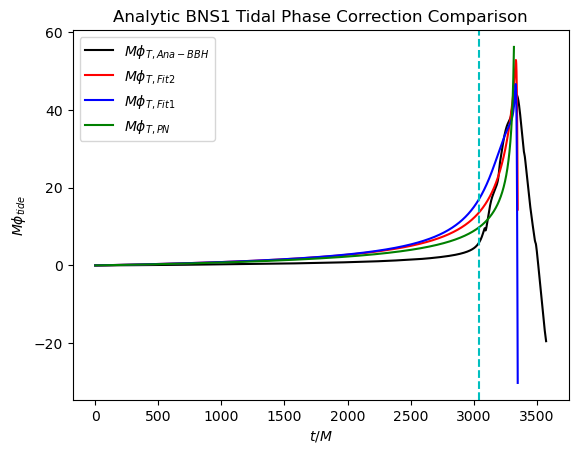

In [85]:
#plot rescaled analytic tides 
numBNS1off = len(BNS1Tshift)-len(Xhybarr[numBNS1ref:numX1mrg])
numBNS2off =  len(BNS2Tshift)-len(Xhybarr[numBNS2ref:numX2mrg])
#print(len(BNS1Tshift[0:-numBNS1off]), len(BNS1ϕTideF2arr))
#print(len(BNS1Tshift),len(Xhybarr[numBNS1ref:numX1mrg]), len(BNS1ϕTideF2arr))
# plot the Phase Difference BNS matched at start 
plt.title("Analytic BNS1 Tidal Phase Correction Comparison")
plt.plot(BNS1Tshift, BNS1ϕTideAna, 'k')
plt.plot(BNS1Tshift[0:-2250], BNS1ϕTideF2arr[0:-2250], 'r')
plt.plot(BNS1Tshift[0:-2250], BNS1ϕTideF1arr[0:-2250], 'b')
plt.plot(BNS1Tshift[0:-2550], BNS1ϕTidePNarr[0:-2550], 'g')
plt.axvline(x=BNS1Tshift[mrgBNS1index], color='c', ls='--')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{tide}$") 
plt.legend(("$M\phi_{T,Ana-BBH}$","$M\phi_{T,Fit2}$", "$M\phi_{T,Fit1}$", "$M\phi_{T,PN}$"),loc="upper left")
print(numBNS1off)
#print(mrgBNS1index,BNS1Tshift[mrgBNS1index],mrgBNS2index, BNS2Tshift[mrgBNS2index])

2888


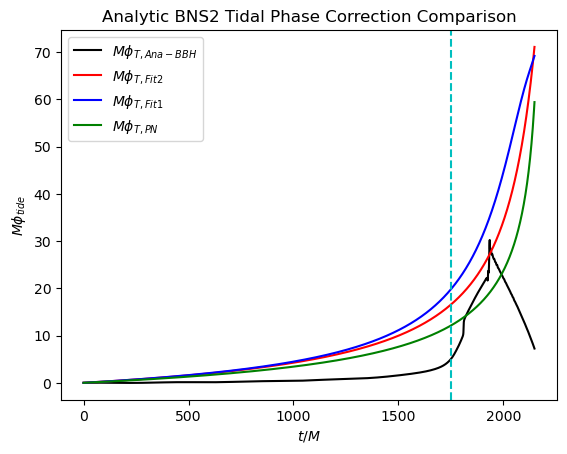

In [86]:
plt.title("Analytic BNS2 Tidal Phase Correction Comparison")
plt.plot(BNS2Tshift, BNS2ϕTideAna, 'k')
plt.plot(BNS2Tshift, BNS2ϕTideF2arr, 'r')
plt.plot(BNS2Tshift, BNS2ϕTideF1arr, 'b')
plt.plot(BNS2Tshift, BNS2ϕTidePNarr, 'g')
plt.axvline(x=BNS2Tshift[mrgBNS2index], color='c', ls='--')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{tide}$") 
plt.legend(("$M\phi_{T,Ana-BBH}$","$M\phi_{T,Fit2}$", "$M\phi_{T,Fit1}$", "$M\phi_{T,PN}$"),loc="upper left")
print(numBNS1off)

In [87]:
#find a better fit with ϕTideAna and ϕTideNR
from scipy.optimize import curve_fit
#now do the curve fit starting from the analytical coefficients for PN fit for BNS 1
tΛ1, tΛ2 = BNS1tΛ, BNS1tΛ
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:numBNS1fin], BNS1ϕTideNR,coeffs_PN,maxfev=150000)
pBNS1matchedcoeffs_PN=popt
BNS1ϕTide_PN = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS1matchedcoeffs_PN)
BNS1ϕTide_PN = BNS1ϕTide_PN - BNS1ϕTide_PN[0]
#plt.plot(BNS1Tshift,BNS1ϕTide_PN)

In [88]:
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:numBNS1fin], BNS1ϕTideNR,coeffs_F1,maxfev=150000)
pBNS1matchedcoeffs_F1=popt
BNS1ϕTide_F1 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS1matchedcoeffs_F1)
BNS1ϕTide_F1 = BNS1ϕTide_F1 - BNS1ϕTide_F1[0]
#plt.plot(BNS1Tshift,BNS1ϕTide_F1)

In [89]:
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:numBNS1fin], BNS1ϕTideNR,coeffs_F2,maxfev=150000)
pBNS1matchedcoeffs_F2=popt
BNS1ϕTide_F2 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS1matchedcoeffs_F2)
BNS1ϕTide_F2 = BNS1ϕTide_F2 - BNS1ϕTide_F2[0]
#plt.plot(BNS1Tshift,BNS1ϕTide_F2)

In [90]:
#fit only up to merger
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:numX1mrg], BNS1ϕTideNR[0:-numBNS1off],coeffs_PN)
pBNS1matchedcoeffsmrg_PN=popt
BNS1ϕTidemrg_PN = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS1matchedcoeffsmrg_PN)
BNS1ϕTidemrg_PN = BNS1ϕTidemrg_PN - BNS1ϕTidemrg_PN[0]
#plt.plot(BNS1Tshift[0:-numBNS1off],BNS1ϕTidemrg_PN[0:-numBNS1off])

In [91]:
#fit only up to merger
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:numX1mrg], BNS1ϕTideNR[0:-numBNS1off],coeffs_F1)
pBNS1matchedcoeffsmrg_F1=popt
BNS1ϕTidemrg_F1 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS1matchedcoeffsmrg_F1)
BNS1ϕTidemrg_F1 = BNS1ϕTidemrg_F1 - BNS1ϕTidemrg_F1[0]
#plt.plot(BNS1Tshift[0:-numBNS1off],BNS1ϕTidemrg_F1[0:-numBNS1off])

In [92]:
#fit only up to merger
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:numX1mrg], BNS1ϕTideNR[0:-numBNS1off],coeffs_F2)
pBNS1matchedcoeffsmrg_F2=popt
BNS1ϕTidemrg_F2 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS1matchedcoeffsmrg_F2)
BNS1ϕTidemrg_F2 = BNS1ϕTidemrg_F2 - BNS1ϕTidemrg_F2[0]
#plt.plot(BNS1Tshift[0:-numBNS1off],BNS1ϕTidemrg_F2[0:-numBNS1off])

In [93]:
#find a better fit with ϕTideAna and ϕTideNR
tΛ1, tΛ2 = BNS2tΛ, BNS2tΛ
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS2ref:numBNS2fin], BNS2ϕTideNR,coeffs_PN)
pBNS2matchedcoeffs_PN=popt
BNS2ϕTide_PN = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*pBNS2matchedcoeffs_PN)
BNS2ϕTide_PN = BNS2ϕTide_PN - BNS1ϕTide_PN[0]
#plt.plot(BNS2Tshift[0:-numBNS2off],BNS2ϕTide_PN[0:-numBNS2off])

In [94]:
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS2ref:numBNS2fin], BNS2ϕTideNR,coeffs_F1)
pBNS2matchedcoeffs_F1=popt
BNS2ϕTide_F1 = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*pBNS2matchedcoeffs_F1)
BNS2ϕTide_F1 = BNS2ϕTide_F1 - BNS1ϕTide_F1[0]
#plt.plot(BNS2Tshift[0:-numBNS2off],BNS2ϕTide_F1[0:-numBNS2off])

In [95]:
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS2ref:numBNS2fin], BNS2ϕTideNR,coeffs_F2)
pBNS2matchedcoeffs_F2=popt
BNS2ϕTide_F2 = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*pBNS2matchedcoeffs_F2)
BNS2ϕTide_F2 = BNS2ϕTide_F2 - BNS1ϕTide_F2[0]
#plt.plot(BNS2Tshift[0:-numBNS2off],BNS2ϕTide_F2[0:-numBNS2off])

In [96]:
#print out initial coefficients and fitted coefficients for both BNS
print("coefficients PN fit for NR BBH","\n")
print("initial coefficients PN paper:\n",coeffs_PN)
print("matched/fitted coeffs PN BNS1:\n",pBNS1matchedcoeffs_PN)
print("matched/fitted coeffs PN BNS1 mrg:\n",pBNS1matchedcoeffsmrg_PN)
print("matched/fitted coeffs PN BNS2:\n",pBNS2matchedcoeffs_PN)

coefficients PN fit for NR BBH 

initial coefficients PN paper:
 [4.99198718 0.         0.         0.         0.         0.
 0.         0.        ]
matched/fitted coeffs PN BNS1:
 [ -76.91014752  423.92154558 -927.89075503  917.92802812 -342.01710368
  -34.17310408  104.82497519  -85.88130624]
matched/fitted coeffs PN BNS1 mrg:
 [ -183.03654479  1669.41175288 -6358.20184467 11373.08987308
 -7871.58488496   -44.50961717   161.55711175  -164.61329068]
matched/fitted coeffs PN BNS2:
 [  -185.28121797   3227.80604812 -20910.89185604  56376.22426938
 -53688.99409019    610.34457757  -3747.29449893   5679.43232311]


In [97]:
#print out initial coefficients and fitted coefficients for both BNS
print("coefficients F1 fit for NR BBH","\n")
print("initial coefficients PN paper:\n",coeffs_F1)
print("matched/fitted coeffs PN BNS1:\n",pBNS1matchedcoeffs_F1)
print("matched/fitted coeffs PN BNS1 mrg:\n",pBNS1matchedcoeffsmrg_F1)
print("matched/fitted coeffs PN BNS2:\n",pBNS2matchedcoeffs_F1)

coefficients F1 fit for NR BBH 

initial coefficients PN paper:
 [ -17.941        57.983      -298.876       964.192      -936.844
  -22.93275824   43.446         0.        ]
matched/fitted coeffs PN BNS1:
 [ -77.44576435  428.56088905 -942.44373009  937.5721902  -351.68670574
  -34.13146777  104.65774951  -85.72277202]
matched/fitted coeffs PN BNS1 mrg:
 [ -183.06093999  1669.7072765  -6359.53602444 11375.75072617
 -7873.56310077   -44.51021135   161.56025795  -164.61743514]
matched/fitted coeffs PN BNS2:
 [  -181.01796372   3213.71655573 -21031.30369141  57006.77738166
 -54459.0593984     626.4468822   -3843.33146135   5822.90945867]


In [98]:
#print out initial coefficients and fitted coefficients for both BNS
print("coefficients F2 fit for NR BBH","\n")
print("initial coefficients F2 paper:\n",coeffs_F2)
print("matched/fitted coeffs F2 BNS1:\n",pBNS1matchedcoeffs_F2)
print("matched/fitted coeffs F2 BNS1 mrg:\n",pBNS1matchedcoeffsmrg_F2)
print("matched/fitted coeffs F2 BNS2:\n",pBNS2matchedcoeffs_F2)

coefficients F2 fit for NR BBH 

initial coefficients F2 paper:
 [ -15.24521282   31.54226286  -80.92595768  312.48173    -342.15498
  -20.2372       39.39624449   -5.36163   ]
matched/fitted coeffs F2 BNS1:
 [ -76.38580213  419.48342601 -914.27468851  899.90206424 -333.28906821
  -34.20132912  104.9326211   -85.98002641]
matched/fitted coeffs F2 BNS1 mrg:
 [ -183.03453561  1669.39052267 -6358.11984815 11372.95218259
 -7871.49912246   -44.50911454   161.55432958  -164.60939674]
matched/fitted coeffs F2 BNS2:
 [  -182.16411468   3202.67322214 -20859.14190021  56403.66773432
 -53810.02082744    615.77023837  -3779.64583072   5727.75328958]


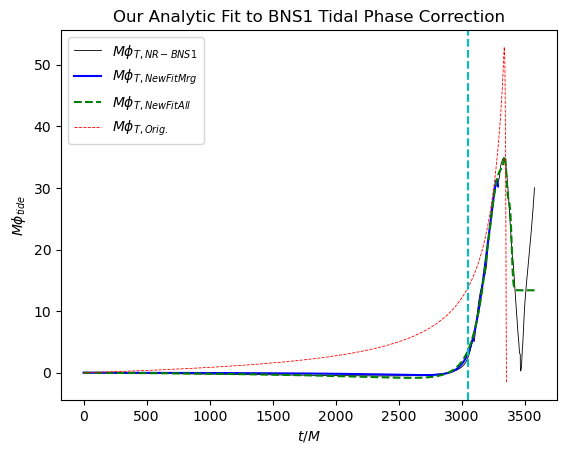

In [99]:
#plot rescaled analytic tides 
# plot the Phase Difference BNS matched at start 
tΛ1, tΛ2 = BNS1tΛ, BNS1tΛ
BNS1ϕTide_BNS2F2 = AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*pBNS2matchedcoeffs_F2)
plt.title("Our Analytic Fit to BNS1 Tidal Phase Correction")
plt.plot(BNS1Tshift, BNS1ϕTideNR, 'k', linewidth=0.6)
#plt.plot(BNS1Tshift, BNS1ϕTide_PN, '-g')
plt.plot(BNS1Tshift[0:mrgBNS1index+2400], BNS1ϕTidemrg_F2[0:mrgBNS1index+2400], 'b')
#plt.plot(BNS1Tshift, BNS1ϕTide_F1, '--b')
plt.plot(BNS1Tshift, BNS1ϕTide_F2, '--g')
#plt.plot(BNS1Tshift, BNS1ϕTide_BNS2F2, '--m')
plt.plot(BNS1Tshift[0:-2225], BNS1ϕTideF2arr[0:-2225], '--r', linewidth=0.6)
plt.axvline(x=BNS1Tshift[mrgBNS1index], color='c', ls='--')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{tide}$") 
plt.legend(("$M\phi_{T,NR-BNS1}$","$M\phi_{T,NewFitMrg}$","$M\phi_{T,NewFitAll}$", "$M\phi_{T,Orig.}$"),loc="upper left")

33321 34321 35740


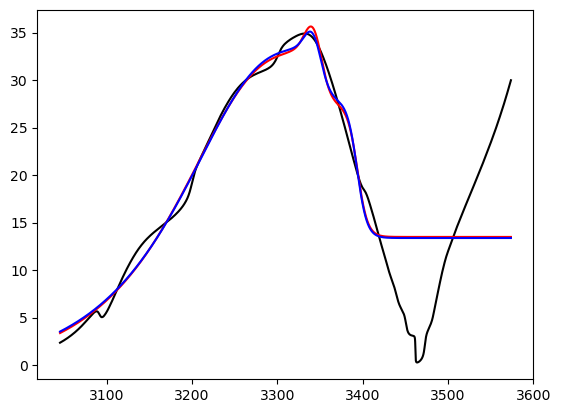

In [100]:
maxcorrectionIDX=np.where(BNS1ϕTideNR==np.max(BNS1ϕTideNR))[0][0]
print(maxcorrectionIDX, len(BNS1ϕTideNR[0:1000+maxcorrectionIDX]), len(BNS1ϕTideNR))
tΛ1, tΛ2 = BNS1tΛ, BNS1tΛ
#popt, a =curve_fit(AnaϕTide(Xhybarr[numBNS1ref:1000+maxcorrectionIDX+numBNS1ref],BNS1ϕTideNR[0:1000+maxcorrectionIDX],coeffs_F2,maxfev=150000)
popt, a =curve_fit(AnaϕTide,Xhybarr[numBNS1ref:1000+maxcorrectionIDX+numBNS1ref], BNS1ϕTideNR[0:1000+maxcorrectionIDX],coeffs_F1,maxfev=150000)
matchedcoeffsAB=popt
ϕTAB=AnaϕTide(Xhybarr[numBNS1ref:numBNS1fin],*matchedcoeffsAB)
ϕTAB=ϕTAB-ϕTAB[0]
plt.plot(BNS1Tshift[mrgBNS1index:-1], BNS1ϕTideNR[mrgBNS1index:-1], 'k')
plt.plot(BNS1Tshift[mrgBNS1index:-1],ϕTAB[mrgBNS1index:-1], 'r')
plt.plot(BNS1Tshift[mrgBNS1index:-1],BNS1ϕTide_F2[mrgBNS1index:-1], 'b')
#plt.plot(BNS1Tshift, BNS1ϕTide_F2-ϕTAB, '--b')

In [101]:
#print out initial coefficients and fitted coefficients for new fit
print("coefficients F2 new fit BNS1","\n")
print("initial coefficients F2 paper:\n",coeffs_F2)
print("matched/fitted coeffs F2:\n",pBNS1matchedcoeffs_F2)
print("matched/fitted coeffs F2mrg:\n",pBNS1matchedcoeffsmrg_F2)
print("matched/fitted coeffs F2 new fit:\n",matchedcoeffsAB)

coefficients F2 new fit BNS1 

initial coefficients F2 paper:
 [ -15.24521282   31.54226286  -80.92595768  312.48173    -342.15498
  -20.2372       39.39624449   -5.36163   ]
matched/fitted coeffs F2:
 [ -76.38580213  419.48342601 -914.27468851  899.90206424 -333.28906821
  -34.20132912  104.9326211   -85.98002641]
matched/fitted coeffs F2mrg:
 [ -183.03453561  1669.39052267 -6358.11984815 11372.95218259
 -7871.49912246   -44.50911454   161.55432958  -164.60939674]
matched/fitted coeffs F2 new fit:
 [ -74.66255646  404.79136103 -868.86711305  839.39223622 -303.82588509
  -34.29792859  105.30756132  -86.32778728]


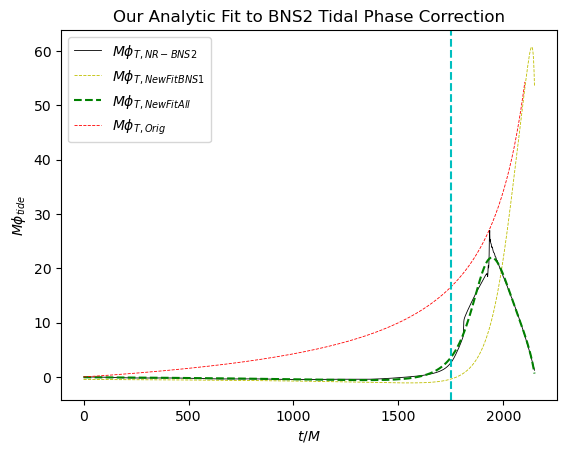

In [102]:
#plot rescaled analytic tides 
# plot the Phase Difference BNS matched at start 
tΛ1, tΛ2 = BNS2tΛ, BNS2tΛ
#BNS2ϕTide_BNS1F2 = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*matchedcoeffsAB)
BNS2ϕTide_BNS1F2 = AnaϕTide(Xhybarr[numBNS2ref:numBNS2fin],*pBNS1matchedcoeffsmrg_F2)
plt.title("Our Analytic Fit to BNS2 Tidal Phase Correction")
plt.plot(BNS2Tshift, BNS2ϕTideNR, 'k', linewidth=0.6)
#plt.plot(BNS2Tshift, BNS2ϕTide_PN, '-g')
#plt.plot(BNS2Tshift, BNS2ϕTide_F1, '-b')
plt.plot(BNS2Tshift, BNS2ϕTide_BNS1F2, '--y',linewidth=0.6)
plt.plot(BNS2Tshift, BNS2ϕTide_F2, '--g')
plt.plot(BNS2Tshift[0:-numBNS2off], BNS2ϕTideF2arr[0:-numBNS2off], '--r',linewidth=0.6)
plt.axvline(x=BNS2Tshift[mrgBNS2index], color='c', ls='--')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{tide}$") 
plt.legend(("$M\phi_{T,NR-BNS2}$","$M\phi_{T,NewFitBNS1}$","$M\phi_{T,NewFitAll}$", "$M\phi_{T,Orig}$"),loc="upper left")

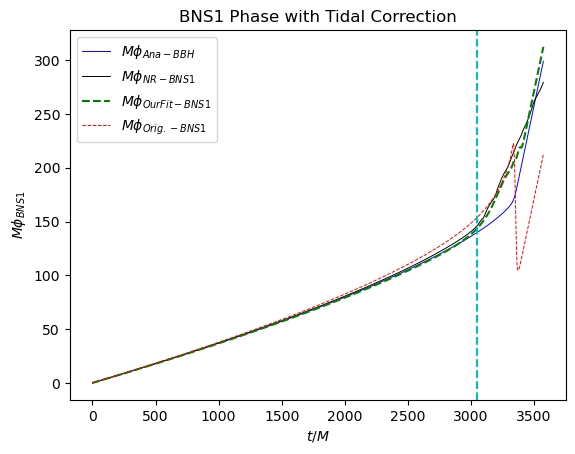

In [103]:
plt.title("BNS1 Phase with Tidal Correction")
plt.plot(BNS1Tshift,Mϕhybarr[numBNS1ref:numBNS1fin]-Mϕhybarr[numBNS1ref],'b', linewidth=0.7)
plt.plot(BNS1Tshift,BNS1ϕintarr-BNS1ϕintarr[0],'k', linewidth=0.7)
plt.plot(BNS1Tshift,BNS1ϕTide_F2+Mϕhybarr[numBNS1ref:numBNS1fin]-(BNS1ϕTide_F2[0]+Mϕhybarr[numBNS1ref]),'--g')
plt.plot(BNS1Tshift,BNS1ϕTideF2arr+Mϕhybarr[numBNS1ref:numBNS1fin]-(BNS1ϕTideF2arr[0]+Mϕhybarr[numBNS1ref]),'--r', linewidth=0.7)
plt.axvline(x=BNS1Tshift[mrgBNS1index], color='c', ls='--')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{BNS1}$") 
plt.legend(("$M\phi_{Ana-BBH}$","$M\phi_{NR-BNS1}$","$M\phi_{OurFit-BNS1}$", "$M\phi_{Orig.-BNS1}$"),loc="upper left")

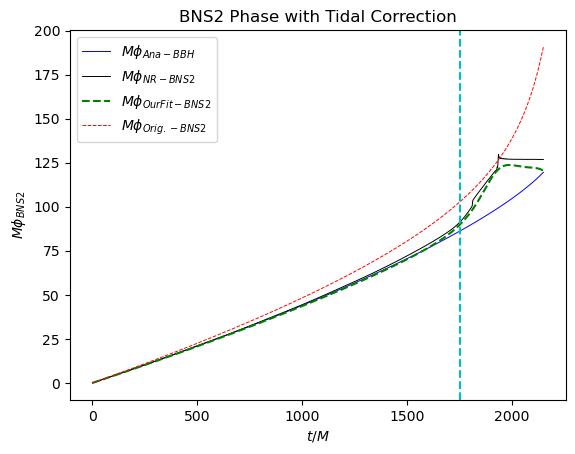

In [104]:
plt.title("BNS2 Phase with Tidal Correction")
plt.plot(BNS2Tshift,Mϕhybarr[numBNS2ref:numBNS2fin]-Mϕhybarr[numBNS2ref],'b', linewidth=0.7)
plt.plot(BNS2Tshift,BNS2ϕintarr-BNS2ϕintarr[0],'k', linewidth=0.7)
plt.plot(BNS2Tshift,BNS2ϕTide_F2+Mϕhybarr[numBNS2ref:numBNS2fin]-(BNS2ϕTide_F2[0]+Mϕhybarr[numBNS2ref]),'--g')
plt.plot(BNS2Tshift,BNS2ϕTideF2arr+Mϕhybarr[numBNS2ref:numBNS2fin]-(BNS2ϕTideF2arr[0]+Mϕhybarr[numBNS2ref]),'--r', linewidth=0.7)
plt.axvline(x=BNS2Tshift[mrgBNS2index], color='c', ls='--')
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{BNS2}$") 
plt.legend(("$M\phi_{Ana-BBH}$","$M\phi_{NR-BNS2}$","$M\phi_{OurFit-BNS2}$", "$M\phi_{Orig.-BNS2}$"),loc="upper left")

### Tapering

In [105]:
#the analytic phase arrays for BBH and BNS1
MϕBBHhybarr = Mϕhybarr[numBNS1ref:numBNS1fin]-Mϕhybarr[numBNS1ref]
MϕBNS1hybarr = MϕBBHhybarr + (BNS1ϕTide_F2 -BNS1ϕTide_F2[0])
MϕBNS1NRarr = BNS1ϕintarr-BNS1ϕintarr[0]

In [106]:
#the analytic phase arrays for BBH and BNS2
MϕBBH2hybarr = Mϕhybarr[numBNS2ref:numBNS2fin]-Mϕhybarr[numBNS2ref]
MϕBNS2hybarr = MϕBBH2hybarr + (BNS2ϕTide_F2 -BNS2ϕTide_F2[0])
MϕBNS2NRarr = BNS2ϕintarr-BNS2ϕintarr[0]

28474
30857
31406
32468
32490
33253
33588
34054


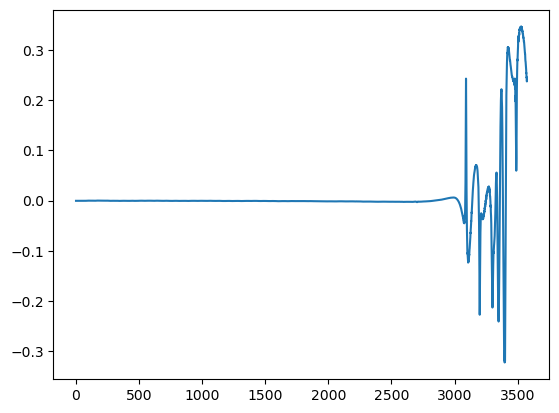

In [107]:
#too noisy to be of any use - attempt to taper
MϕBNS1diff=MϕBNS1hybarr-MϕBNS1NRarr
#plt.plot(BNS1Tshift,MϕBNS1diff)
MϕBNS1diff_dot=np.gradient(MϕBNS1diff,BNS1Tshift) #fun name to say..."difference dot" lol
plt.plot(BNS1Tshift,MϕBNS1diff_dot)

#outputs where derivative of difference wrt time goes from negative to positive...possible cutoff points (want to find element after the "small hump around t=3000")
cutoffs=[]
for i in range(len(MϕBNS1diff_dot)-1):
    if MϕBNS1diff_dot[i+1]>=0 and MϕBNS1diff_dot[i]<=0:
        cutoffs.append(i)
        print(i)

941
15766
18168
19116
19138
19156
19175
19194
19213
19235
19282
19350
19378
19467
19563
19635
19704
19770
19779
19876
19958
19981
19989
20045
20123
20139
20232
20240
20327
20402
20483
20540
20604
20678
20891
21055
17502


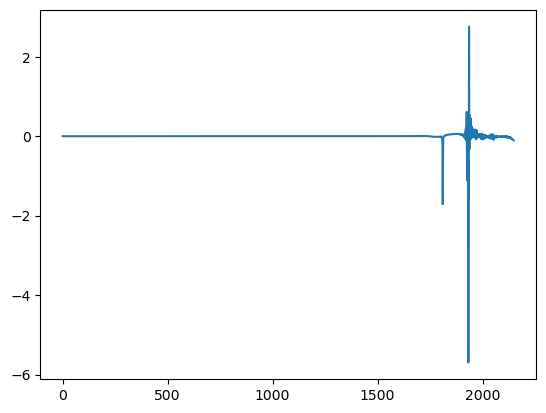

In [108]:
#too noisy to be of any use - attempt to taper
MϕBNS2diff=MϕBNS2hybarr-MϕBNS2NRarr
#plt.plot(BNS1Tshift,MϕBNS1diff)
MϕBNS2diff_dot=np.gradient(MϕBNS2diff,BNS2Tshift) #fun name to say..."difference dot" lol
plt.plot(BNS2Tshift,MϕBNS2diff_dot)

#outputs where derivative of difference wrt time goes from negative to positive...possible cutoff points (want to find element after the "small hump around t=3000")
cutoffs2=[]
for i in range(len(MϕBNS2diff_dot)-1):
    if MϕBNS2diff_dot[i+1]>=0 and MϕBNS2diff_dot[i]<=0:
        cutoffs2.append(i)
        print(i)
print(mrgBNS2index)

In [109]:
#generating all "corrected/tapered phase-candidates" at once and making/appending to a list 
#where each element in the list is one of these "phase arrays"
Listofphasearrays=[]
for i in range(len(cutoffs)):
    MϕBNS1Tidal=np.zeros(len(BNS1Tshift))
    for idx in range(0,cutoffs[i]):
        MϕBNS1Tidal[idx]=BNS1ϕTide_F2[idx]+Mϕhybarr[numBNS1ref+idx]-(BNS1ϕTide_F2[0]+Mϕhybarr[numBNS1ref])
    for idx in range(cutoffs[i],len(BNS1Tshift)):
        MϕBNS1Tidal[idx]=Mϕhybarr[numBNS1ref+idx]+(BNS1ϕTide_F2[cutoffs[i]-1])-(BNS1ϕTide_F2[0]+Mϕhybarr[numBNS1ref])    
    Listofphasearrays.append( MϕBNS1Tidal)

In [110]:
Listofphasearrays2=[]
for i in range(len(cutoffs2)):
    MϕBNS2Tidal=np.zeros(len(BNS2Tshift))
    for idx in range(0,cutoffs2[i]):
        MϕBNS2Tidal[idx]=BNS2ϕTide_F2[idx]+Mϕhybarr[numBNS2ref+idx]-(BNS2ϕTide_F2[0]+Mϕhybarr[numBNS2ref])
    for idx in range(cutoffs2[i],len(BNS2Tshift)):
        MϕBNS2Tidal[idx]=Mϕhybarr[numBNS2ref+idx]+(BNS2ϕTide_F2[cutoffs2[i]-1])-(BNS2ϕTide_F2[0]+Mϕhybarr[numBNS2ref])    
    Listofphasearrays2.append( MϕBNS2Tidal)

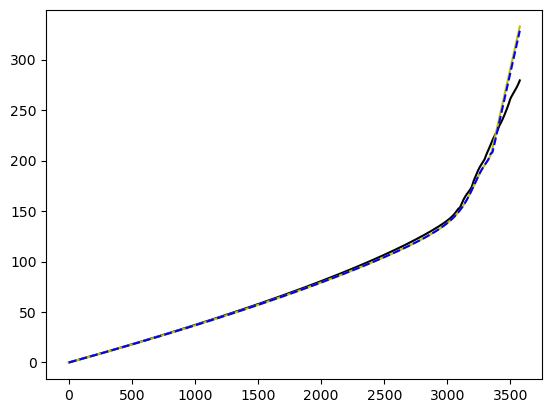

In [111]:
#print(len(cutoffs1))
plt.plot(BNS1Tshift,MϕBNS1NRarr,'k',label="NR phase for BNS 1")
#plt.plot(BNS1Tshift,Listofphasearrays1[0],'b')
#plt.plot(BNS1Tshift,Listofphasearrays1[1],'g')
#plt.plot(BNS1Tshift,Listofphasearrays1[2],'c')
#plt.plot(BNS1Tshift,Listofphasearrays1[3],'r')
#plt.plot(BNS1Tshift,Listofphasearrays1[4],'m')
plt.plot(BNS1Tshift,Listofphasearrays[5],'y')
plt.plot(BNS1Tshift,Listofphasearrays[6],'--b')
#plt.plot(BNS1Tshift,Listofphasearrays[7],'--g')

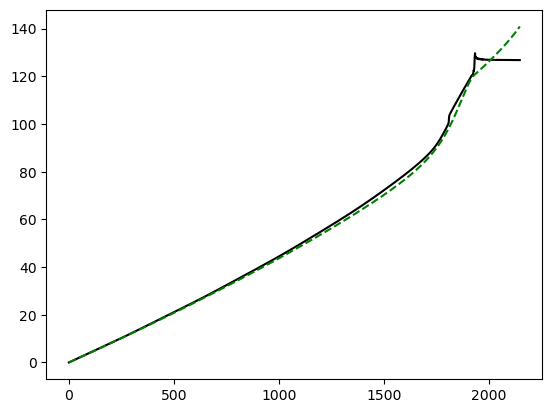

In [112]:
#print(len(cutoffs2))
plt.plot(BNS2Tshift,MϕBNS2NRarr,'k',label="NR phase for BNS 2")
#plt.plot(BNS2Tshift,Listofphasearrays2[10],'b')
#plt.plot(BNS2Tshift,Listofphasearrays2[11],'g')
#plt.plot(BNS2Tshift,Listofphasearrays2[12],'c')
#plt.plot(BNS2Tshift,Listofphasearrays2[13],'r')
#plt.plot(BNS2Tshift,Listofphasearrays2[14],'m')
#plt.plot(BNS2Tshift,Listofphasearrays2[15],'y')
#plt.plot(BNS2Tshift,Listofphasearrays2[3],'--b')
plt.plot(BNS2Tshift,Listofphasearrays2[9],'--g')

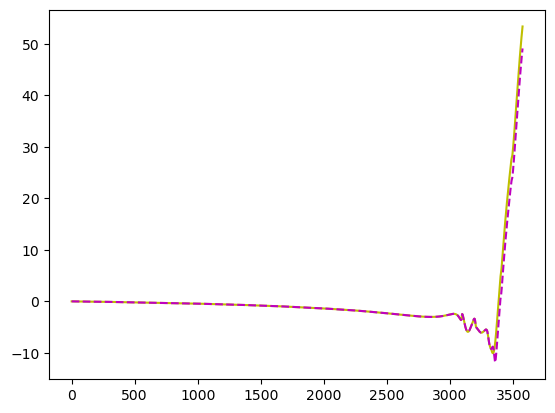

In [113]:
#plt.plot(BNS1Tshift,MϕBNS1NRarr,'k',label="NR phase for BNS 1")
#plt.plot(BNS1Tshift,Listofphasearrays1[0]-MϕBNS1NRarr,'k')
#plt.plot(BNS1Tshift,Listofphasearrays1[1]-MϕBNS1NRarr,'b')
#plt.plot(BNS1Tshift,Listofphasearrays1[2]-MϕBNS1NRarr,'g')
#plt.plot(BNS1Tshift,Listofphasearrays1[3]-MϕBNS1NRarr,'r')
#plt.plot(BNS1Tshift,Listofphasearrays1[4]-MϕBNS1NRarr,'c')
plt.plot(BNS1Tshift,Listofphasearrays[5]-MϕBNS1NRarr,'y')
plt.plot(BNS1Tshift,Listofphasearrays[6]-MϕBNS1NRarr,'--m')
#plt.plot(BNS1Tshift,Listofphasearrays1[7]-MϕBNS1NRarr,'--k')

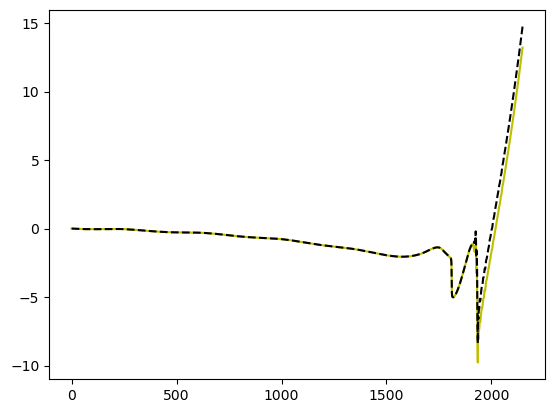

In [114]:
#plt.plot(BNS2Tshift,MϕBNS1NRarr,'k',label="NR phase for BNS 1")
#plt.plot(BNS2Tshift,Listofphasearrays2[0]-MϕBNS2NRarr,'k')
#plt.plot(BNS2Tshift,Listofphasearrays2[1]-MϕBNS2NRarr,'b')
#plt.plot(BNS2Tshift,Listofphasearrays2[2]-MϕBNS2NRarr,'g')
#plt.plot(BNS2Tshift,Listofphasearrays2[3]-MϕBNS2NRarr,'r')
#plt.plot(BNS2Tshift,Listofphasearrays2[4]-MϕBNS2NRarr,'c')
plt.plot(BNS2Tshift,Listofphasearrays2[3]-MϕBNS2NRarr,'y')
#plt.plot(BNS2Tshift,Listofphasearrays2[7]-MϕBNS2NRarr,'--m')
plt.plot(BNS2Tshift,Listofphasearrays2[13]-MϕBNS2NRarr,'--k')

In [115]:
#making life easier with a function rather than copy and pasting code to plot "candidates"
def plotpotentialcurve(i):
    plt.plot(BNS1Tshift,Listofphasearrays[i],'r')
    plt.plot(BNS1Tshift,MϕBNS1NRarr,'k',label="NR phase for BNS 1")    
    plt.legend()
    print("index of cutoff time in BNS1Tshift corresponding to this plot=",cutoffs[i])
    print("here, cutoff time=",BNS1Tshift[cutoffs[i]])

In [116]:
def plotpotentialcurve2(i):
    plt.plot(BNS2Tshift,Listofphasearrays2[i],'r')
    plt.plot(BNS2Tshift,MϕBNS2NRarr,'k',label="NR phase for BNS 2")    
    plt.legend()
    print("index of cutoff time in BNS2Tshift corresponding to this plot=",cutoffs2[i])
    print("here, cutoff time=",BNS2Tshift[cutoffs2[i]])

index of cutoff time in BNS1Tshift corresponding to this plot= 33253
here, cutoff time= 3325.2999999969757


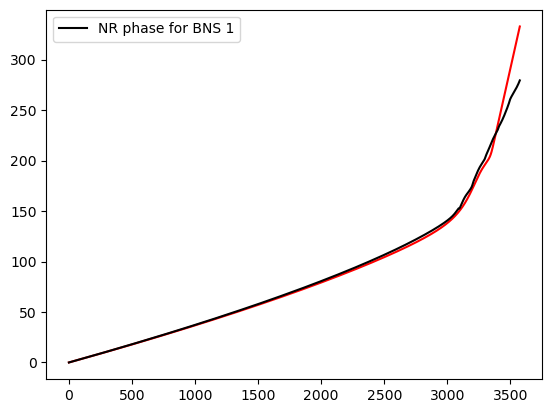

In [117]:
plotpotentialcurve(5)

index of cutoff time in BNS2Tshift corresponding to this plot= 21055
here, cutoff time= 2105.499999998085


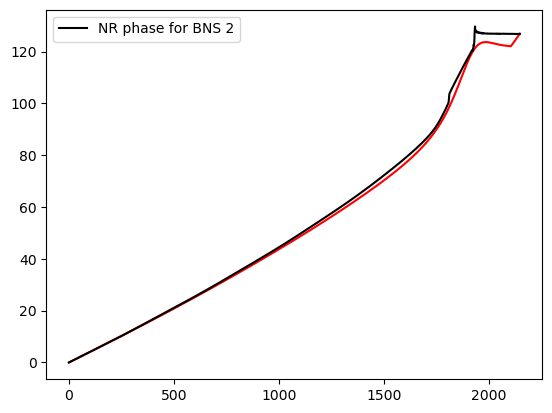

In [118]:
plotpotentialcurve2(35)

In [119]:
print("best cutoff:","\n","index of cutoff time=",cutoffs[5],'\n',"cutoff time=",BNS1Tshift[cutoffs[5]])
print("end time:","\n",BNS1Tshift[-1])

best cutoff: 
 index of cutoff time= 33253 
 cutoff time= 3325.2999999969757
end time: 
 3573.8999999967496


In [120]:
print("best cutoff 2:","\n","index of cutoff time=",cutoffs2[5],'\n',"cutoff time=",BNS2Tshift[cutoffs2[5]])
print("end time:","\n",BNS2Tshift[-1])

best cutoff 2: 
 index of cutoff time= 19156 
 cutoff time= 1915.5999999982578
end time: 
 2148.399999998046


In [121]:
print("corrected/tapered phase using a heaviside*correction where heaviside=0 for all t>3325.3\nand=1 for all other t",'\n','\nname of array:','Listofphasearrays[5]')  

corrected/tapered phase using a heaviside*correction where heaviside=0 for all t>3325.3
and=1 for all other t 
 
name of array: Listofphasearrays[5]


In [122]:
print("corrected/tapered phase using a heaviside*correction where heaviside=0 for all t>3325.3\nand=1 for all other t",'\n','\nname of array:','Listofphasearrays2[5]')

corrected/tapered phase using a heaviside*correction where heaviside=0 for all t>3325.3
and=1 for all other t 
 
name of array: Listofphasearrays2[5]


In [123]:
MϕBNS1hybarr_hvs=Listofphasearrays[5]
#print(len(BNS1Tshift[mrgBNS1index:]),len(BNS1ϕTideF2arr[mrgBNS1index:]), len(Mϕhybarr[numBNS1ref+mrgBNS1index:numBNS1fin]))

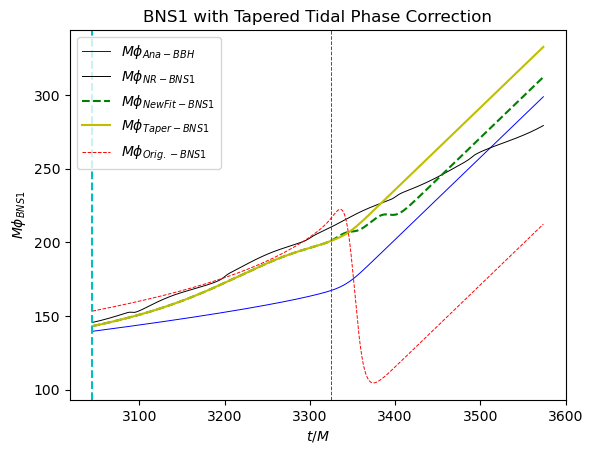

In [124]:
#plt.figure(figsize=(6,6))
#title_font = {'size':'26'}
plt.title("BNS1 with Tapered Tidal Phase Correction")
plt.plot(BNS1Tshift[mrgBNS1index:],MϕBBHhybarr[mrgBNS1index:],'b', linewidth=0.7)
plt.plot(BNS1Tshift[mrgBNS1index:],MϕBNS1NRarr[mrgBNS1index:],'k', linewidth=0.7)
plt.plot(BNS1Tshift[mrgBNS1index:],MϕBNS1hybarr[mrgBNS1index:],'--g')
#plt.plot(BNS1Tshift,MϕBNS1hybarr_hvs3,'y')
plt.plot(BNS1Tshift[mrgBNS1index:],MϕBNS1hybarr_hvs[mrgBNS1index:],'y')
plt.plot(BNS1Tshift[mrgBNS1index:],BNS1ϕTideF2arr[mrgBNS1index:]+Mϕhybarr[numBNS1ref+mrgBNS1index:numBNS1fin]-(BNS1ϕTideF2arr[0]+Mϕhybarr[numBNS1ref]),'--r', linewidth=0.7)
plt.axvline(x=BNS1Tshift[mrgBNS1index], color='c', ls='--')
plt.axvline(x=BNS1Tshift[cutoffs[5]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{BNS1}$") 
plt.legend(("$M\phi_{Ana-BBH}$","$M\phi_{NR-BNS1}$","$M\phi_{NewFit-BNS1}$","$M\phi_{Taper-BNS1}$", "$M\phi_{Orig.-BNS1}$"),loc="upper left")

In [125]:
print(len(BNS1Tshift), len(BNS1ϕTideF2arr[numBNS1ref:numBNS1fin]))

35740 34502


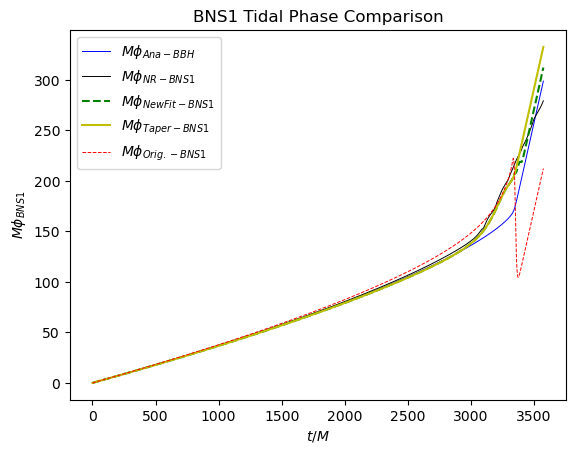

In [126]:
#plt.figure(figsize=(6,6))
#title_font = {'size':'26'}
plt.title("BNS1 Tidal Phase Comparison")
plt.plot(BNS1Tshift,MϕBBHhybarr,'b', linewidth=0.7)
plt.plot(BNS1Tshift,MϕBNS1NRarr,'k', linewidth=0.7)
plt.plot(BNS1Tshift,MϕBNS1hybarr,'--g')
plt.plot(BNS1Tshift,MϕBNS1hybarr_hvs,'y')
plt.plot(BNS1Tshift,BNS1ϕTideF2arr+Mϕhybarr[numBNS1ref:numBNS1fin]-(BNS1ϕTideF2arr[0]+Mϕhybarr[numBNS1ref]),'--r', linewidth=0.7)
#plt.axvline(x=BNS1Tshift, color='c', ls='--')
#plt.axvline(x=BNS1Tshift[cutoffs[5]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{BNS1}$") 
plt.legend(("$M\phi_{Ana-BBH}$","$M\phi_{NR-BNS1}$","$M\phi_{NewFit-BNS1}$","$M\phi_{Taper-BNS1}$", "$M\phi_{Orig.-BNS1}$"),loc="upper left")

In [127]:
MϕBNS2hybarr_hvs=Listofphasearrays2[10]
#print(len(BNS2Tshift[mrgBNS2index:]),len(BNS2ϕTideF2arr[mrgBNS2index:]), len(Mϕhybarr[numBNS2ref+mrgBNS2index:numBNS2fin]))

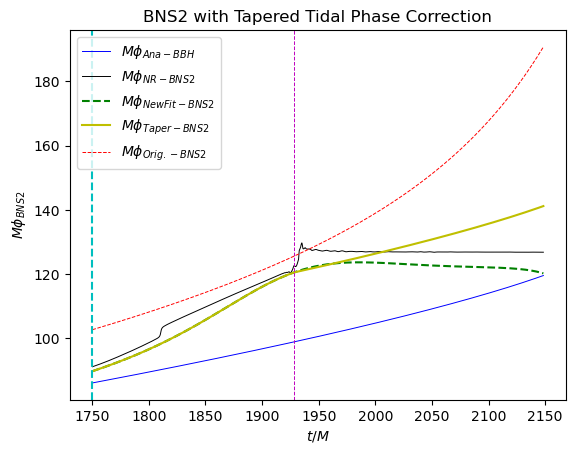

In [128]:
#plt.figure(figsize=(6,6))
#title_font = {'size':'26'}
plt.title("BNS2 with Tapered Tidal Phase Correction")
plt.plot(BNS2Tshift[mrgBNS2index:],MϕBBH2hybarr[mrgBNS2index:],'b', linewidth=0.7)
plt.plot(BNS2Tshift[mrgBNS2index:],MϕBNS2NRarr[mrgBNS2index:],'k', linewidth=0.7)
plt.plot(BNS2Tshift[mrgBNS2index:],MϕBNS2hybarr[mrgBNS2index:],'--g')
#plt.plot(BNS1Tshift,MϕBNS1hybarr_hvs3,'y')
plt.plot(BNS2Tshift[mrgBNS2index:],MϕBNS2hybarr_hvs[mrgBNS2index:],'y')
plt.plot(BNS2Tshift[mrgBNS2index:],BNS2ϕTideF2arr[mrgBNS2index:]+Mϕhybarr[numBNS2ref+mrgBNS2index:numBNS2fin]-(BNS2ϕTideF2arr[0]+Mϕhybarr[numBNS2ref]),'--r', linewidth=0.7)
plt.axvline(x=BNS2Tshift[mrgBNS2index], color='c', ls='--')
plt.axvline(x=BNS2Tshift[cutoffs2[10]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{BNS2}$") 
plt.legend(("$M\phi_{Ana-BBH}$","$M\phi_{NR-BNS2}$","$M\phi_{NewFit-BNS2}$","$M\phi_{Taper-BNS2}$", "$M\phi_{Orig.-BNS2}$"),loc="upper left")

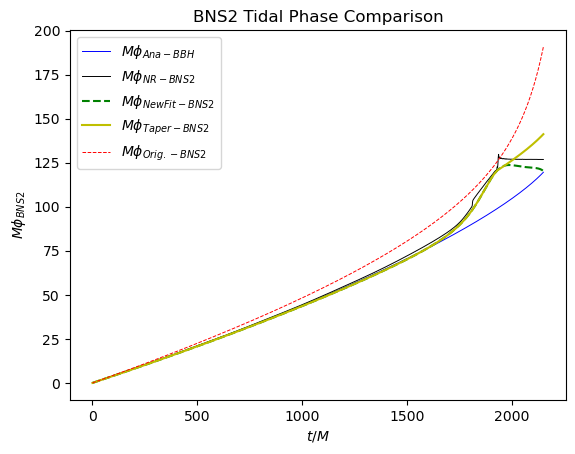

In [129]:
#plt.figure(figsize=(6,6))
#title_font = {'size':'26'}
plt.title("BNS2 Tidal Phase Comparison")
plt.plot(BNS2Tshift,MϕBBH2hybarr,'b', linewidth=0.7)
plt.plot(BNS2Tshift,MϕBNS2NRarr,'k', linewidth=0.7)
plt.plot(BNS2Tshift,MϕBNS2hybarr,'--g')
plt.plot(BNS2Tshift,MϕBNS2hybarr_hvs,'y')
plt.plot(BNS2Tshift,BNS2ϕTideF2arr+Mϕhybarr[numBNS2ref:numBNS2fin]-(BNS2ϕTideF2arr[0]+Mϕhybarr[numBNS2ref]),'--r', linewidth=0.7)
#plt.axvline(x=BNS1Tshift, color='c', ls='--')
#plt.axvline(x=BNS1Tshift[cutoffs[5]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$M\phi_{BNS2}$") 
plt.legend(("$M\phi_{Ana-BBH}$","$M\phi_{NR-BNS2}$","$M\phi_{NewFit-BNS2}$","$M\phi_{Taper-BNS2}$", "$M\phi_{Orig.-BNS2}$"),loc="upper left")

####  Now we implement the amplitude correction.
We stop it at the cuttoff

In [130]:
Tcutoff = cutoffs[5]
Tcutoff2 = cutoffs2[10]

In [131]:
#Analytic tide amplitude function
def AnaAmpTide(x, d,p):
    kTeff = (3./16.)*(tΛ1+tΛ2)
    
    fact = (1./84.)*(np.sqrt((np.pi)/(5.)))*kTeff
    num = (x**6)*(672.-11.*x)
    den = (1.+(d*x**p))
    
    AmpTide = fact*num/den

    return (AmpTide)

# the analytical approximation for merger amplitude
kTeff1 = (3./16.)*(BNS1tΛ+BNS1tΛ)
AnaAmrg = 1.6498*(1.+2.5603*(e-2)*(kTeff1)-1.024*(e-5)*(kTeff1)**2) \
        /(1+4.7278*(e-2)*(kTeff1))

In [132]:
#computing "initial value"/"initial guess" for free parameter d
Xmerge = Xhybarr[numBNS1ref+mrgBNS1index]
Amerge=BNS1Ampintarr[mrgBNS1index]

print(Amerge,AnaAmrg)
p = 1 #power of XpN
tΛ1,tΛ2 = BNS1tΛ, BNS1tΛ
dA=(1./Xmerge)*((AnaAmpTide(Xmerge,0, p)/Amerge)-1.)
dAnaA=(1./Xmerge)*((AnaAmpTide(Xmerge,0, p)/AnaAmrg)-1.)
print(dA, dAnaA)

1.000003341193772 -105.08542443389294
-8.827637859069249 -8.862314799420105


In [133]:
#analytic approximation for the tidal amplitude
initialAcoeffs = np.array([dA,p])
tΛ1,tΛ2 = BNS1tΛ, BNS1tΛ
BNS1ATide = AnaAmpTide(Xhybarr[numBNS1ref:numBNS1ref+Tcutoff],*initialAcoeffs)-AnaAmpTide(Xhybarr[numBNS1ref],dA, p)
BNS1ATidearr = np.array(BNS1ATide).flatten()

In [134]:
#analytic approximation for the tidal amplitude
initialAnaAcoeffs = np.array([dAnaA,p])
tΛ1,tΛ2 = BNS1tΛ, BNS1tΛ
BNS1AnaATide = AnaAmpTide(Xhybarr[numBNS1ref:numBNS1ref+Tcutoff],*initialAnaAcoeffs)-AnaAmpTide(Xhybarr[numBNS1ref],*initialAnaAcoeffs)
BNS1AnaATidearr = np.array(BNS1AnaATide).flatten()

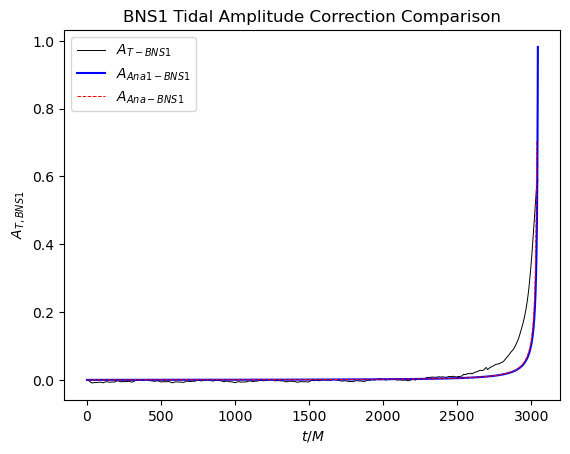

In [135]:
plt.title("BNS1 Tidal Amplitude Correction Comparison")
#plt.plot(BNS1Tshift[0:Tcutoff],BNS1AmpTideNR[0:Tcutoff],'b', linewidth=0.7)
plt.plot(BNS1Tshift[0:mrgBNS1index],BNS1AmpTideNR[0:mrgBNS1index],'k', linewidth=0.7)
plt.plot(BNS1Tshift[0:mrgBNS1index],BNS1ATidearr[0:mrgBNS1index],'b')
plt.plot(BNS1Tshift[0:mrgBNS1index-80],BNS1AnaATidearr[0:mrgBNS1index-80],'--r', linewidth=0.7)
#plt.axvline(x=BNS1Tshift[cutoffs[5]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$A_{T, BNS1}$") 
plt.legend(("$A_{T-BNS1}$","$A_{Ana1-BNS1}$","$A_{Ana-BNS1}$"),loc="upper left")

In [136]:
#fitting up to cutoff
tΛ1,tΛ2 = BNS1tΛ, BNS1tΛ
popt, a =curve_fit(AnaAmpTide,Xhybarr[numBNS1ref:numBNS1ref+Tcutoff],BNS1AmpTideNR[0:Tcutoff],initialAcoeffs,maxfev=150000)
matchedAcoeffs=popt

In [137]:
print("original coefficients (from paper):","\n",initialAcoeffs)
print("matched coefficients (matched to BNS1):","\n",matchedAcoeffs)

original coefficients (from paper): 
 [-8.82763786  1.        ]
matched coefficients (matched to BNS1): 
 [-8.31345652  0.973248  ]


In [138]:
#fitting up to cutoff
tΛ1,tΛ2 = BNS1tΛ, BNS1tΛ
popt, a =curve_fit(AnaAmpTide,Xhybarr[numBNS1ref:numBNS1ref+Tcutoff],BNS1AmpTideNR[0:Tcutoff],initialAnaAcoeffs,maxfev=150000)
matchedAnaAcoeffs=popt

In [139]:
print("original coefficients (from paper):","\n",initialAnaAcoeffs)
print("matched coefficients (matched to BNS1):","\n",matchedAnaAcoeffs)

original coefficients (from paper): 
 [-8.8623148  1.       ]
matched coefficients (matched to BNS1): 
 [-8.86230038  1.00000074]


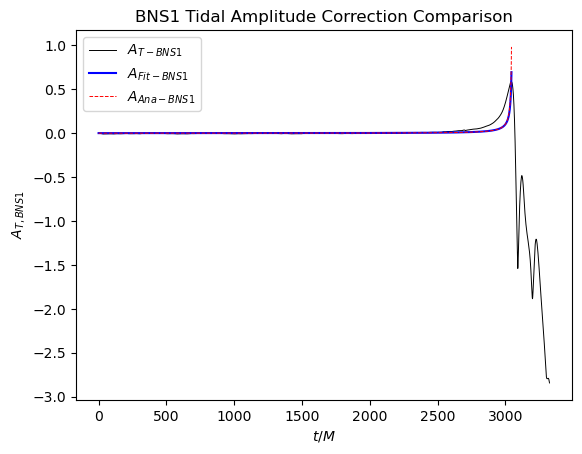

In [140]:
#reconstructed amplitude
tΛ1,tΛ2 = BNS1tΛ, BNS1tΛ
BNS1ATidefit = AnaAmpTide(Xhybarr[numBNS1ref:numBNS1ref+Tcutoff],*matchedAcoeffs)

plt.title("BNS1 Tidal Amplitude Correction Comparison")
#plt.plot(BNS1Tshift[0:Tcutoff],BNS1AmpTideNR[0:Tcutoff],'b', linewidth=0.7)
plt.plot(BNS1Tshift[0:Tcutoff],BNS1AmpTideNR[0:Tcutoff],'k', linewidth=0.7)
plt.plot(BNS1Tshift[0:mrgBNS1index],BNS1ATidefit[0:mrgBNS1index],'b')
plt.plot(BNS1Tshift[0:mrgBNS1index],BNS1ATidearr[0:mrgBNS1index],'--r', linewidth=0.7)
#plt.axvline(x=BNS1Tshift[cutoffs[5]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$A_{T, BNS1}$") 
plt.legend(("$A_{T-BNS1}$","$A_{Fit-BNS1}$","$A_{Ana-BNS1}$"),loc="upper left")

2803 2803


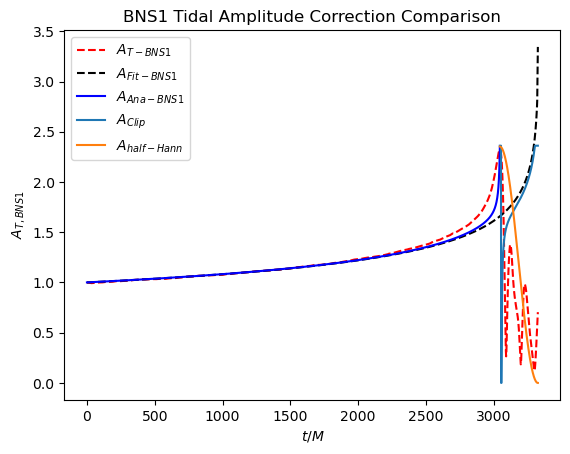

In [141]:
#attempt to cutoff the amplitude at merger

AmpBNS1premrg=np.zeros(Tcutoff)
p=0
for i in BNS1ATidefit[0:Tcutoff]:
    AmpBNS1premrg[p]=i+AnaBBH1Aintarr[p]/AnaBBH1Aintarr[0]
    p=p+1

A_min = 0
A_max = AmpBNS1premrg[mrgBNS1index]
#Aclip = np.clip(( AmpBNS1premrg[mrgBNS1index:Tcutoff] - A_max) / (A_max - A_min), A_min, A_max)
Aclip = np.clip(AmpBNS1premrg[mrgBNS1index:Tcutoff], A_min,A_max)

# could we apply a hanning tapering window?
AmpBNS1pm=np.zeros(mrgBNS1index)
p=0
for i in BNS1ATidefit[0:mrgBNS1index]:
    AmpBNS1pm[p]=i+AnaBBH1Aintarr[p]/AnaBBH1Aintarr[0]
    p=p+1

AmpBNS1han = AmpBNS1pm[-1]*np.hanning(2*(Tcutoff-(mrgBNS1index+1)))
halfPoint = np.argmax(AmpBNS1han)
AmpBNS1han = AmpBNS1han[halfPoint:]

print(len(BNS1Tshift[mrgBNS1index:Tcutoff]), len(AmpBNS1han))

#plt.plot(BNS1Tshift[0:mrgBNS1index],AmpBNS1pm)
#plt.plot(BNS1Tshift[mrgBNS1index:Tcutoff],AmpBNS1han)

#plot
plt.title("BNS1 Tidal Amplitude Correction Comparison")
plt.plot(BNS1Tshift[0:Tcutoff],BNS1Ampintarr[0:Tcutoff]/BNS1Ampintarr[0],'--r')
plt.plot(BNS1Tshift[0:Tcutoff],AnaBBH1Aintarr[0:Tcutoff]/AnaBBH1Aintarr[0],'--k')
plt.plot(BNS1Tshift[0:mrgBNS1index],AmpBNS1premrg[0:mrgBNS1index],'b')
plt.plot(BNS1Tshift[mrgBNS1index:Tcutoff],Aclip)
plt.plot(BNS1Tshift[mrgBNS1index:Tcutoff],AmpBNS1han)
plt.xlabel("$t/M$")
plt.ylabel("$A_{T, BNS1}$") 
plt.legend(("$A_{T-BNS1}$","$A_{Fit-BNS1}$","$A_{Ana-BNS1}$","$A_{Clip}$","$A_{half-Hann}$" ),loc="upper left")

In [142]:
#do the same for BNS2
Xmerge2 = Xhybarr[numBNS2ref+mrgBNS2index]
Amerge2=BNS2Ampintarr[mrgBNS2index]

# the analytical approximation for merger amplitude
kTeff2 = (3./16.)*(BNS2tΛ+BNS2tΛ)
AnaAmrg2 = 1.6498*(1.+2.5603*(e-2)*(kTeff2)-1.024*(e-5)*(kTeff2)**2) \
        /(1+4.7278*(e-2)*(kTeff2))

print(Amerge2,AnaAmrg2)
p2 = 1 #power of XpN
tΛ1,tΛ2 = BNS2tΛ, BNS2tΛ
dA2=(1./Xmerge2)*((AnaAmpTide(Xmerge2,0, p2)/Amerge2)-1.)
dAnaA2=(1./Xmerge2)*((AnaAmpTide(Xmerge2,0, p2)/AnaAmrg2)-1.)
print(dA2, dAnaA2)

0.9684937462202481 -205.43709134836774
-9.594098759120337 -9.63966856897634


In [143]:
#analytic approximation for the tidal amplitude
initialAcoeffs2 = np.array([dA2,p2])
tΛ1,tΛ2 = BNS2tΛ, BNS2tΛ
BNS2ATide = AnaAmpTide(Xhybarr[numBNS2ref:numBNS2ref+Tcutoff],*initialAcoeffs2)-AnaAmpTide(Xhybarr[numBNS2ref],dA2, p2)
BNS2ATidearr = np.array(BNS2ATide).flatten()

In [144]:
#fitting up to cutoff

popt, a =curve_fit(AnaAmpTide,Xhybarr[numBNS2ref:numBNS2ref+Tcutoff2],BNS2AmpTideNR[0:Tcutoff2],initialAcoeffs2,maxfev=150000)
matchedAcoeffs2=popt

In [145]:
print("original coefficients (from paper):","\n",initialAcoeffs2)
print("matched coefficients (matched to BNS1):","\n",matchedAcoeffs2)

original coefficients (from paper): 
 [-9.59409876  1.        ]
matched coefficients (matched to BNS1): 
 [-9.5228056   0.99671266]


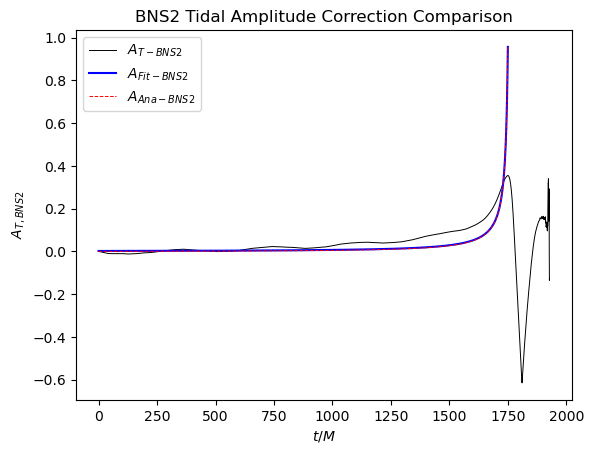

In [146]:
#reconstructed amplitude
tΛ1,tΛ2 = BNS2tΛ, BNS2tΛ
BNS2ATidefit = AnaAmpTide(Xhybarr[numBNS2ref:numBNS2ref+Tcutoff2],*matchedAcoeffs2)

plt.title("BNS2 Tidal Amplitude Correction Comparison")
#plt.plot(BNS1Tshift[0:Tcutoff],BNS1AmpTideNR[0:Tcutoff],'b', linewidth=0.7)
plt.plot(BNS2Tshift[0:Tcutoff2],BNS2AmpTideNR[0:Tcutoff2],'k', linewidth=0.7)
plt.plot(BNS2Tshift[0:mrgBNS2index],BNS2ATidefit[0:mrgBNS2index],'b')
plt.plot(BNS2Tshift[0:mrgBNS2index],BNS2ATidearr[0:mrgBNS2index],'--r', linewidth=0.7)
#plt.axvline(x=BNS1Tshift[cutoffs[5]], color='m', ls='--', linewidth=0.7)
plt.xlabel("$t/M$")
plt.ylabel("$A_{T, BNS2}$") 
plt.legend(("$A_{T-BNS2}$","$A_{Fit-BNS2}$","$A_{Ana-BNS2}$"),loc="upper left")

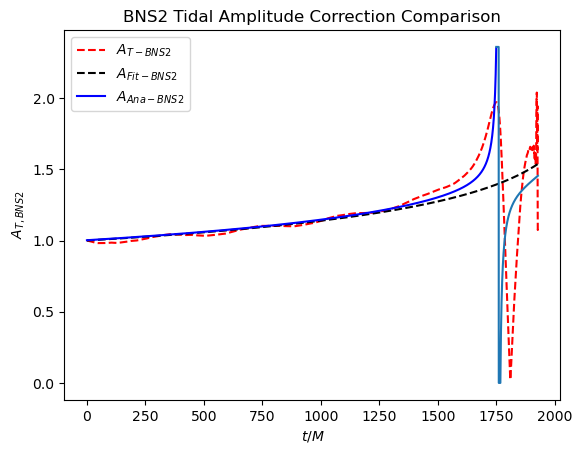

In [147]:
#attempt to cutoff the amplitude at merger

AmpBNS2premrg=np.zeros(Tcutoff2)
p=0
for i in BNS2ATidefit[0:Tcutoff2]:
    AmpBNS2premrg[p]=i+AnaBBH2Aintarr[p]/AnaBBH2Aintarr[0]
    p=p+1

A2_min = 0
A2_max = AmpBNS2premrg[mrgBNS2index]
#Aclip = np.clip(( AmpBNS1premrg[mrgBNS1index:Tcutoff] - A_max) / (A_max - A_min), A_min, A_max)
Aclip2 = np.clip(AmpBNS2premrg[mrgBNS2index:Tcutoff2], A2_min,A2_max)

#plot
plt.title("BNS2 Tidal Amplitude Correction Comparison")
plt.plot(BNS2Tshift[0:Tcutoff2],BNS2Ampintarr[0:Tcutoff2]/BNS2Ampintarr[0],'--r')
plt.plot(BNS2Tshift[0:Tcutoff2],AnaBBH2Aintarr[0:Tcutoff2]/AnaBBH2Aintarr[0],'--k')
plt.plot(BNS2Tshift[0:mrgBNS2index],AmpBNS2premrg[0:mrgBNS2index],'b')
plt.plot(BNS2Tshift[mrgBNS2index:Tcutoff2],Aclip2)
plt.xlabel("$t/M$")
plt.ylabel("$A_{T, BNS2}$") 
plt.legend(("$A_{T-BNS2}$","$A_{Fit-BNS2}$","$A_{Ana-BNS2}$"),loc="upper left")

In [148]:
BNS2AmpRTideNR = BNS2AmpRatioTideNR-BNS2AmpRatioTideNR[0]
#plt.plot(BNS2Tshift, BNS2AmpTideNR, 'k')
#plt.plot(BNS2Tshift, BNS2AmpRTideNR, 'r')

In [149]:
#fitting up to cutoff for the ratio in amplitude

BNS2AmpRTideNR = BNS2AmpRatioTideNR-BNS2AmpRatioTideNR[0]
popt, a =curve_fit(AnaAmpTide,Xhybarr[numBNS2ref:numBNS2ref+Tcutoff2],BNS2AmpRTideNR[0:Tcutoff2],initialAcoeffs2,maxfev=150000)
matchedAcoeffs2_R=popt

In [150]:
print("original coefficients (from paper):","\n",initialAcoeffs2)
print("matched coefficients (matched to BNS1):","\n",matchedAcoeffs2_R)

original coefficients (from paper): 
 [-9.59409876  1.        ]
matched coefficients (matched to BNS1): 
 [-9.5238205   0.99675979]


In [151]:
#reconstructed amplitude
#tΛ1,tΛ2 = BNS2tΛ, BNS2tΛ
#BNS2ATidefitR = AnaAmpTide(Xhybarr[numBNS2ref:numBNS2ref+Tcutoff2],*matchedAcoeffs2_R)

#plt.plot(BNS2Tshift[0:Tcutoff2-1800], BNS2ATidefit[0:-1800], 'k')
#plt.plot(BNS2Tshift[0:Tcutoff2-1800], BNS2ATidefitR[0:-1800], '--y')
#plt.plot(BNS2Tshift, BNS2AmpRTideNR, 'r')